# Spotify API: Music Data Analysis

# Introduction - 
- The Cross-API Music Data Analysis project is an endeavor to harness the power of data to gain valuable insights into the music industry. Being an Artist who has their Songs on Spotify, Apple Music and other platforms I had to explore how Spotify's Algorithm Analyzes the songs and what Insights i can get out of the Data with my Creative Eye.

## Objectives
The primary objectives of this project are to:
- Integrate and analyze music data from diverse sources, including Spotify, Last.fm, and Billboard.
- Create a relational database to facilitate efficient data querying and analysis.
- Develop predictive models to identify trends in audio features.
- Visualize key insights using Tableau dashboards.
- Address critical business questions related to artist popularity, social media influence, and music trends.
## Data Sources
 This project leverages data from the following sources:
- Spotify: Provides comprehensive music data, including audio features, top artists, and tracks.
- Last.fm: Offers insights into artist popularity, tags, and listener behavior.
- Billboard: Supplies data on chart performance and rankings.
- Social Media Platforms: Potential sources for artist-related social data.

## Scope of the Project
 The project scope encompasses:
- Extracting, transforming, and loading data from multiple sources.
- Storing structured data in a MySQL relational database.
- Developing predictive models to uncover patterns in audio features.
- Visualizing insights through Tableau dashboards.
- Addressing key business questions about music industry trends.
- In this report, we will provide detailed information on each phase of the project, from data collection to visualization. Additionally, #### we will highlight the business value and questions addressed through this analysis. 

# Loading Required Libraries 

In [ ]:
# Data Collection and Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, r2_score, precision_score,
    recall_score, confusion_matrix, f1_score,
    classification_report, roc_auc_score, accuracy_score
)

from yellowbrick.regressor import PredictionError, ResidualsPlot
# Data Transformation and Encoding
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    RandomForestRegressor, XGBClassifier, XGBRegressor
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from yellowbrick.target import FeatureCorrelation

# Data Visualization
warnings.filterwarnings("ignore")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

# Spotify API Integration
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Data Loading and Cleaning
import util  # Assuming this is a custom utility module for data loading

# Data Visualization Configuration
sns.set(style="whitegrid")
matplotlib.rcParams.update({'font.size': 12})



# Data Extraction - Exploring Spotify API

- Starting with data extraction, I have provided a function to get data of any artist you want, or search any track,album,artist.
- I will also Play around a Bit to explore the connections and then we will extract data from Last FM API Charts to get the top artists, we will then try to find them out in Billboard Charts by extracting data from Billboard API

In [113]:
##Using Client Credentials to get access token for Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

idcl ="xx" 
clsec = "xx"

client_credentials_manager = SpotifyClientCredentials(client_id=idcl, client_secret=clsec)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
# Define list of artist names
artist_names = ["The Weeknd"]

# Function to get all tracks from an album
def get_album_tracks(album_id):
    tracks = []
    results = sp.album_tracks(album_id)
    tracks.extend(results['items'])

    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])

    return tracks

# Initialize empty list to store track data
all_tracks_data = []

# Loop through each artist
for artist_name in artist_names:
    # Search for the artist
    results = sp.search(q='artist:' + artist_name, type='artist')
    if len(results['artists']['items']) > 0:
        artist = results['artists']['items'][0]
        artist_id = artist['id']

        # Get all albums of the artist
        albums = sp.artist_albums(artist_id, album_type='album', limit=50)['items']

        # Loop through each album
        for album in albums:
            album_id = album['id']
            album_name = album['name']

            # Get all tracks from the album
            album_tracks = get_album_tracks(album_id)

            # Loop through each track
            for track in album_tracks:
                track_id = track['id']
                track_name = track['name']

                # Get audio features for the track
                audio_features = sp.audio_features(track_id)
                
                # Get track popularity
                track_info = sp.track(track_id)
                track_popularity = track_info['popularity']
                
                track_data = {
                    'artist': artist_name,
                    'album': album_name,
                    'track_name': track_name,
                    'track_id': track_id,
                    'track_popularity': track_popularity
                }

                if audio_features:
                    track_data.update(audio_features[0])

                all_tracks_data.append(track_data)

print(all_tracks_data)


In [ ]:
pd.DataFrame(all_tracks_data)

#### First, I'll Search for my artist profile by artist name 'Yash Vaid' to get my artist ID and then extract track data. I make peaceful Lofi songs , you can check out "MY MUSIC" by clicking [here ](https://yashvaidmusic.my.canva.site/)


In [ ]:
## First we run a self search
artist_names = ["Yash Vaid"]
artist_ids = []
for artist_name in artist_names:
    results = sp.search(q='artist:' + artist_name,
type='artist')
    
    if len(results['artists']['items']) > 0:
        artist_id = results['artists']['items'][0]['id']
        artist_ids.append(artist_id)
    else:
        print(f"No artist found with name {artist_name}")

print(artist_ids)

Now we search by a track of the artist "Tune Kaha" then retireve top tracks

In [ ]:
yashtracks = []
results = sp.search(q='track:Tune kaha (Reprise)', type='track')
if results['tracks']['total'] > 0:
    track = results['tracks']['items'][0]
    track_name = track['name']
    track_uri = track['uri']
    track_id = track['id']
    track_popularity = track['popularity']
    artist_id = track['artists'][0]['id']
    artist_name = track['artists'][0]['name']
    #retrieve all tracks associated with the artist
    artist_tracks = sp.artist_top_tracks(artist_id)
    for track in artist_tracks['tracks']:
        yashtracks.append({'name': track['name'], 'id': track['id'], 'artist_name': artist_name, 'artist_id': artist_id,
                       'track_uri': track_uri, 'track_id': track_id, 'track_popularity': track_popularity})
else:
    print("Track not found.")

print(yashtracks)


The using names and ids of tracks we get the features of each track

In [ ]:
yash_tracks_with_features = []
for track in yashtracks:
    track_id = track['id']
    audio_features = sp.audio_features(track_id)
    track.update(audio_features[0])
    yash_tracks_with_features.append(track)
print(yash_tracks_with_features)


Then we convert it into a dataframe to be converted as a csv file 

In [ ]:
yash_tracks_df = pd.DataFrame(yash_tracks_with_features)
yash_tracks_df.to_csv('yashtracks.csv',index=False)

#### Now we add the artists i'm inspired from and want to compare my audio features with

In [ ]:
## Full Search
artist_names = ["Sleepy Fish","Jeremy Zucker","Shallou","Chance Pena","Anumita Nadesan","Prateek Kuhad","MITRAZ","Shashwat Sachdev","Hashir","Novo Amor","Montell Fish","Fiji Blue","Mixed Matches","Petit Biscuit","Vierre Cloud","Anuv Jain","Sammie Singh","Frank Ocean","EDEN","Purrple Cat","PinkPantheress","San Holo","Keshi","OneHeart","Honey Ivy","Philantrope","Ben Bohmer","Cristian Jefferies","Shamoon Ismail"]
artist_ids = []
tracks = []

for artist_name in artist_names:
    results = sp.search(q='artist:' + artist_name, type='artist')
    if len(results['artists']['items']) > 0:
        artist_id = results['artists']['items'][0]['id']
        artist_ids.append(artist_id)
        artist_tracks = sp.artist_top_tracks(artist_id)
        for track in artist_tracks['tracks']:
            tracks.append({'name': track['name'], 'id': track['id'], 'artist_name': artist_name, 'artist_id': artist_id,
                           'track_uri': track['uri'], 'track_popularity': track['popularity']})
    else:
        print(f"No artist found with name {artist_name}")

print(artist_ids)
print(tracks)


Similarly we get their features by using their track ids in a list format 

In [ ]:
tracks_with_features = []
for track in tracks:
    track_id = track['id']
    audio_features = sp.audio_features(track_id)
    track.update(audio_features[0])
    tracks_with_features.append(track)
print(tracks_with_features)

Then we convert it into a dataframe , appen it with my own data, to be converted as a csv file 

In [ ]:
import pandas as pd

tracks_df = pd.DataFrame(tracks_with_features)
tracks_df.to_csv('tracks.csv',index=False)

all_tracks = tracks_df.append(yash_tracks_df, ignore_index=True)
Final_data = pd.DataFrame(all_tracks)
Final_data.to_csv('Data_spotify.csv',index=False)
print(Final_data)


# Data Extraction - Last Fm Artist List

- For extracting data throigh Last Fm API you will need another API key . In the last fm API we fetch the top artists from the charts, we feth their tags and then similar artists with their tags. The tags will help us to cluter artists 

In [118]:
# Last.fm API key and shared secret
API_KEY = "250cf7be14101d8d7fa9137d64bc7e8d"
SHARED_SECRET = "46a092d1c8d032f21b09c1ae43e3cd33"


In [119]:
import requests
import pandas as pd

def lastfm_api_request(url):
    response = requests.get(url)
    
    try:
        response_json = response.json()
        return response_json
    except Exception as e:
        print("Error parsing API response:", e)
        print("Response text:", response.text)
        return {}

def get_top_artists(limit=50):
    url = f"https://ws.audioscrobbler.com/2.0/?method=chart.getTopArtists&api_key={API_KEY}&format=json&limit={limit}"
    response = lastfm_api_request(url)
    return response["artists"]["artist"]

def get_similar_artists(artist_name, limit=20):
    url = f"https://ws.audioscrobbler.com/2.0/?method=artist.getsimilar&artist={artist_name}&api_key={API_KEY}&format=json&limit={limit}"
    response = lastfm_api_request(url)
    return response["similarartists"]["artist"]

def get_top_tags(artist_name, limit= 10):
    url = f"https://ws.audioscrobbler.com/2.0/?method=artist.gettoptags&artist={artist_name}&api_key={API_KEY}&format=json"
    response = lastfm_api_request(url)
    return response["toptags"]["tag"]

if __name__ == "__main__":
    # Get top artists
    top_artists = get_top_artists(limit=50)
    top_artists_df = pd.DataFrame(top_artists)
    top_artists_df.to_csv("top_artists_batch4luluu.csv", index=False)

    # Collect data for similar artists
    artists_data_similar = []
    for artist in top_artists:
        top_artist_name = artist["name"]

        # Get similar artists for the top artist
        similar_artists = get_similar_artists(top_artist_name, limit= 40)
        
        # Collect data for similar artists
        for similar_artist in similar_artists:
            artists_data_similar.append({"top_artist": top_artist_name, "similar_artist": similar_artist["name"], "match": similar_artist["match"]})

    similar_artists_df = pd.DataFrame(artists_data_similar)
    
    similar_artists_df.to_csv("similar_artists_batch4luluu.csv", index=False)
    
    
    # Collect data for top artists and their similar artists' tags
    artists_data_tags = []
    for artist in top_artists:
        top_artist_name = artist["name"]
        tag_artists = get_top_tags(top_artist_name)
        for tag in tag_artists:
            artists_data_tags.append({"artist": top_artist_name, "tag": tag["name"], "url": tag["url"], "count": tag["count"]})

    tags_artists_df = pd.DataFrame(artists_data_tags)
    tags_artists_df.to_csv("tags_artists_batch4luluuu.csv", index=False)

     # Collect data for similar artists and their tags
    artists_data_similar_tags = []
     # Get top tags for each similar artist
    for similar_artist in similar_artists:
        similar_artist_name = similar_artist["name"]
        similar_artist_tags = get_top_tags(similar_artist_name, limit=5)
            
        # Collect data for tags
        for tag in similar_artist_tags:
            artists_data_similar_tags.append({"artist": similar_artist_name, "tag": tag["name"], "url": tag["url"], "count": tag["count"]})

    tags_artists_df = pd.DataFrame(similar_artist_tags)
    tags_artists_df.to_csv("tags_similar_artists_batch4luluuu.csv", index=False)
    


# Data Extraction - for Spotify , Last FM Cross Analysis

- For our Cross Analysis, we will take the artist list obtained from last fm and then find out their data on Spotify

In [ ]:

# Process artists in batches of 10
batch_size = 10
num_batches = (len(similar_artists_df) // batch_size) + 1

for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = (batch_num + 1) * batch_size

    batch_data = similar_artists_df.iloc[start_idx:end_idx]

    batch_top_artist_data = []
    batch_top_tracks_data = []
    batch_similar_artist_data = []
    batch_related_artists_data = []

    for index, row in batch_data.iterrows():
        top_artist_name = row["top_artist"]
        similar_artist_name = row["similar_artist"]

        # Step 3: Get Artist Data from Spotify
        search_results_top = sp.search(q='artist:' + top_artist_name, type='artist', limit=1)["artists"]["items"]
        if search_results_top:
            top_artist_data = search_results_top[0]
            batch_top_artist_data.append(top_artist_data)

            # Step 4: Get Top Tracks of Top Artist
            top_tracks = sp.artist_top_tracks(top_artist_data['id'])['tracks']
            batch_top_tracks_data.extend(top_tracks)

            # Step 5: Get Similar Artist Data from Spotify
            search_results_similar = sp.search(q='artist:' + similar_artist_name, type='artist', limit=1)["artists"]["items"]
            if search_results_similar:
                similar_artist_data = search_results_similar[0]
                batch_similar_artist_data.append(similar_artist_data)

                # Step 6: Get Related Artists of Similar Artist
                related_artists = sp.artist_related_artists(similar_artist_data['id'])['artists']
                batch_related_artists_data.extend(related_artists)

    # Convert the extracted data into DataFrames
    batch_top_artist_df = pd.DataFrame(batch_top_artist_data)
    batch_top_tracks_df = pd.DataFrame(batch_top_tracks_data)
    batch_similar_artist_df = pd.DataFrame(batch_similar_artist_data)
    batch_related_artists_df = pd.DataFrame(batch_related_artists_data)

    # Save the DataFrames to separate CSV files for the current batch
    batch_top_artist_filename = f"batch_{batch_num + 1}_toppp_artist_data.csv"
    batch_top_tracks_filename = f"batch_{batch_num + 1}_topppp_tracks_data.csv"
    batch_similar_artist_filename = f"batch_{batch_num + 1}_similar_artist_data.csv"
    batch_related_artists_filename = f"batch_{batch_num + 1}_related_artists_data.csv"

    batch_top_artist_df.to_csv(batch_top_artist_filename, index=False)
    batch_top_tracks_df.to_csv(batch_top_tracks_filename, index=False)
    batch_similar_artist_df.to_csv(batch_similar_artist_filename, index=False)
    batch_related_artists_df.to_csv(batch_related_artists_filename, index=False)


## Data Extraction : Billboard API

In [ ]:
pip install billboard.py
import billboard
import pandas as pd


- So what we'll basically do is , take the artist data obtained from spotify and top tracks data , we would join them on Artist and theri track names and then we will search in some charts of billboard API to see if we find them

In [ ]:
import billboard
import pandas as pd

# Load your artist names data from the CSV file
artist_names_df = pd.read_csv("main_artist_names_lastfm.csv")

# List of chart types to analyze
chart_types = [
    'artist-100',           # Billboard Artist 100
    'digital-song-sales',   # Digital Song Sales
    'streaming-songs',      # Streaming Songs
    'billboard-200',        # Billboard 200
    'billboard-global-200', # Billboard Global 200
    'hot-r-and-and-b-songs',# Hot R&B Songs
    'hot-rock-songs',
    'radio-songs',
    'soundtracks'
          # Hot Rock & Alternative Songs
    # Add more chart types as needed
]

# Initialize a list to store analysis results
analysis_results = []

# Iterate through each artist name in the DataFrame
for index, row in artist_names_df.iterrows():
    artist_name = str(row["top_artist"])  # Replace with the column name containing artist names
    
    artist_info = {"artist_name": artist_name}
    
    # Iterate through each chart type
    for chart_type in chart_types:
        chart = billboard.ChartData(chart_type)
        
        # Find entries that match the artist's name
        matching_entries = [entry for entry in chart if entry.artist == artist_name]
        
         # Extract relevant information from the matching entries
        chart_data = {
            "chart_type": chart_type,
            "chart_entries": len(matching_entries),
            # Extract other attributes as needed
        }
        
        # Extract additional attributes and longevity information
        song_titles = []
        peak_positions = []
        weeks_on_chart = []
        
        for entry in matching_entries:
            song_titles.append(entry.title)
            peak_positions.append(entry.peakPos)
            weeks_on_chart.append(entry.weeks)
        
        chart_data["song_titles"] = song_titles
        chart_data["peak_positions"] = peak_positions
        chart_data["weeks_on_chart"] = weeks_on_chart
        
        artist_info[chart_type] = chart_data
    
    analysis_results.append(artist_info)


billboard_analysis_df = pd.DataFrame(analysis_results)

billboard_analysis_df.to_csv("billboard_artist_analysis_results.csv", index=False)


In [ ]:


# Load data from billboard.csv
billboard_data = pd.read_csv("billboard_artist_analysis_results.csv")

# Create separate DataFrames for each chart
chart_dfs = {}
for index, row in billboard_data.iterrows():
    artist_name = row["artist_name"]
    for chart_type in row.index:
        if chart_type != "artist_name":
            chart_info = eval(row[chart_type])
            df = pd.DataFrame(chart_info)
            df["artist_name"] = artist_name
            chart_dfs.setdefault(chart_type, []).append(df)

# Merge the DataFrames based on the artist's name
merged_dfs = {}
for chart_type, dfs in chart_dfs.items():
    merged_dfs[chart_type] = pd.concat(dfs, ignore_index=True)

# Example: Accessing the merged DataFrame for 'artist-100' chart
artist_100_df = merged_dfs["artist-100"]
print(artist_100_df)

digital_song_sales = merged_dfs["digital-song-sales"]
print(digital_song_sales)


streaming_songs = merged_dfs["streaming-songs"]
print(streaming_songs)

billboard_200 = merged_dfs["billboard-200"]
print(billboard_200)

billboard_global_200 = merged_dfs["billboard-global-200"]
print(billboard_global_200)

hot_rnb = merged_dfs["hot-r-and-and-b-songs"]
print(hot_rnb)

billboard_global_200 = merged_dfs["billboard-global-200"]
print(billboard_global_200)

radio_songs = merged_dfs["radio-songs"]
print(radio_songs)



- We extracted the data from Billboard API and the split it according to different charts, the data provides number of weeks, peak positions , number of songs of an artists obtained in the search 

####This completes our data extraction part 

# DATA EXPLORATION - Audio Features 

- Now we will have a meet n greet with our data, although I had to do do alot of splitting , merging and cleaning of all the csv files to get one data file with information of a lot of tracks so that we can analyze the popularity based on Audio-Features, as well as their popularity on different platforms.  

- Note - The two datasets we will work with have been extracted from a single source i.e Spotify API. The Songs_11k df will be the data of random list of artists that i admire and like, which we will "Statistically" & "Visually" compare and see what is the difference between top artists given by Last.FM vs data of random artists. Also Consider Using The Data Extraction Functions to extract your own data if needed.   

In [34]:
songs_11k = pd.read_csv(r'C:\Users\yjain\Spotify Project\tracks_spotify_abhi.csv', index_col='Unnamed: 0')
songs_lastfmlist = pd.read_csv(r'C:\Users\yjain\Spotify Project\audiofeat_toptracks_spotify.csv')

We can see the Popularity of the Tracks with their respective Audio Features retrieved using the artist and tracks IDs

In [35]:
songs_11k.sample(10)


,artist,album,track_name,track_id,track_popularity,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1429,Post Malone,Hollywood's Bleeding,Wow.,0aMiATaLkj7ffT4W9Ng0TM,54,0.842,0.545,11,-7.289,0,...,0.1020,0.3810,99.991,audio_features,0aMiATaLkj7ffT4W9Ng0TM,spotify:track:0aMiATaLkj7ffT4W9Ng0TM,https://api.spotify.com/v1/tracks/0aMiATaLkj7f...,https://api.spotify.com/v1/audio-analysis/0aMi...,149533,4
2302,Justin Bieber,Never Say Never - The Remixes,Born To Be Somebody,1gWnUzwTMhOv4cWyj1CDxB,44,0.674,0.619,1,-5.239,1,...,0.0493,0.2960,117.927,audio_features,1gWnUzwTMhOv4cWyj1CDxB,spotify:track:1gWnUzwTMhOv4cWyj1CDxB,https://api.spotify.com/v1/tracks/1gWnUzwTMhOv...,https://api.spotify.com/v1/audio-analysis/1gWn...,181027,4
2292,Justin Bieber,Believe (Deluxe Edition),Believe,3GSS1kpoOUlbN3QffsjOpQ,0,0.519,0.854,0,-5.710,1,...,0.1710,0.5080,159.805,audio_features,3GSS1kpoOUlbN3QffsjOpQ,spotify:track:3GSS1kpoOUlbN3QffsjOpQ,https://api.spotify.com/v1/tracks/3GSS1kpoOUlb...,https://api.spotify.com/v1/audio-analysis/3GSS...,222560,4
2961,The Weeknd,Kiss Land (Deluxe MENA Version),Odd Look,5NWZKYemdvViFPnwmOcl3M,19,0.588,0.848,10,-5.869,0,...,0.1160,0.2660,104.938,audio_features,5NWZKYemdvViFPnwmOcl3M,spotify:track:5NWZKYemdvViFPnwmOcl3M,https://api.spotify.com/v1/tracks/5NWZKYemdvVi...,https://api.spotify.com/v1/audio-analysis/5NWZ...,252493,4
1842,Ariana Grande,My Everything (Italian Edition),One Last Time - Gazzo Remix,5ZUEGiZXJAINc3fDBbbYlW,8,0.645,0.913,5,-4.413,0,...,0.4420,0.4770,125.060,audio_features,5ZUEGiZXJAINc3fDBbbYlW,spotify:track:5ZUEGiZXJAINc3fDBbbYlW,https://api.spotify.com/v1/tracks/5ZUEGiZXJAIN...,https://api.spotify.com/v1/audio-analysis/5ZUE...,246973,4
1246,Ed Sheeran,Loose Change,Let It Out,69RasNFxqhiyy75JDHsrIS,47,0.731,0.603,8,-7.656,1,...,0.1470,0.6190,96.973,audio_features,69RasNFxqhiyy75JDHsrIS,spotify:track:69RasNFxqhiyy75JDHsrIS,https://api.spotify.com/v1/tracks/69RasNFxqhiy...,https://api.spotify.com/v1/audio-analysis/69Ra...,231547,4
897,Ed Sheeran,= (Tour Edition),Collide,78zI7ExbtXPO8LwxhZZzeQ,9,0.672,0.730,5,-4.770,1,...,0.0612,0.5590,123.969,audio_features,78zI7ExbtXPO8LwxhZZzeQ,spotify:track:78zI7ExbtXPO8LwxhZZzeQ,https://api.spotify.com/v1/tracks/78zI7ExbtXPO...,https://api.spotify.com/v1/audio-analysis/78zI...,210213,4
1822,Ariana Grande,Dangerous Woman,Touch It,6WikCGNUbXFmXoLre7vjeW,63,0.536,0.694,7,-4.369,0,...,0.1830,0.2930,100.899,audio_features,6WikCGNUbXFmXoLre7vjeW,spotify:track:6WikCGNUbXFmXoLre7vjeW,https://api.spotify.com/v1/tracks/6WikCGNUbXFm...,https://api.spotify.com/v1/audio-analysis/6Wik...,260000,4
337,Drake,What A Time To Be Alive,30 for 30 Freestyle,1DmnEYXa4WfbdhAPwNzgD8,56,0.744,0.619,4,-9.143,0,...,0.1230,0.3170,89.252,audio_features,1DmnEYXa4WfbdhAPwNzgD8,spotify:track:1DmnEYXa4WfbdhAPwNzgD8,https://api.spotify.com/v1/tracks/1DmnEYXa4Wfb...,https://api.spotify.com/v1/audio-analysis/1Dmn...,253935,4


In [36]:
songs_lastfmlist.sample(10)

,popularity,name,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1181,78,SWEET / I THOUGHT YOU WANTED TO DANCE (feat. B...,spotify:track:3EG9FJ0ToLfgnc1IG2Z1wz,0.468,0.652,0.0,-4.912,1.0,0.0722,0.33300,...,0.5500,0.390,140.223,audio_features,3EG9FJ0ToLfgnc1IG2Z1wz,spotify:track:3EG9FJ0ToLfgnc1IG2Z1wz,https://api.spotify.com/v1/tracks/3EG9FJ0ToLfg...,https://api.spotify.com/v1/audio-analysis/3EG9...,588139.0,4.0
1470,78,Open Arms (feat. Travis Scott),spotify:track:6koKhrBBcExADvWuOgceNZ,0.434,0.586,9.0,-7.612,1.0,0.1380,0.75300,...,0.1460,0.239,78.259,audio_features,6koKhrBBcExADvWuOgceNZ,spotify:track:6koKhrBBcExADvWuOgceNZ,https://api.spotify.com/v1/tracks/6koKhrBBcExA...,https://api.spotify.com/v1/audio-analysis/6koK...,239613.0,4.0
2359,58,Jennifer's Body,spotify:track:6wAdJF85cna96BwQn2Pg8c,0.401,0.863,11.0,-7.312,0.0,0.0447,0.00079,...,0.1740,0.550,81.650,audio_features,6wAdJF85cna96BwQn2Pg8c,spotify:track:6wAdJF85cna96BwQn2Pg8c,https://api.spotify.com/v1/tracks/6wAdJF85cna9...,https://api.spotify.com/v1/audio-analysis/6wAd...,220533.0,4.0
261,89,Viva La Vida,spotify:track:1mea3bSkSGXuIRvnydlB5b,0.486,0.617,5.0,-7.115,0.0,0.0287,0.09540,...,0.1090,0.417,138.015,audio_features,1mea3bSkSGXuIRvnydlB5b,spotify:track:1mea3bSkSGXuIRvnydlB5b,https://api.spotify.com/v1/tracks/1mea3bSkSGXu...,https://api.spotify.com/v1/audio-analysis/1mea...,242373.0,4.0
200,88,CUFF IT,spotify:track:1xzi1Jcr7mEi9K2RfzLOqS,0.780,0.689,7.0,-5.668,1.0,0.1410,0.03680,...,0.0698,0.642,115.042,audio_features,1xzi1Jcr7mEi9K2RfzLOqS,spotify:track:1xzi1Jcr7mEi9K2RfzLOqS,https://api.spotify.com/v1/tracks/1xzi1Jcr7mEi...,https://api.spotify.com/v1/audio-analysis/1xzi...,225389.0,4.0
908,77,Her Way,spotify:track:3JEJwjqLkg2Jbau5922CAb,0.542,0.487,1.0,-9.530,1.0,0.0286,0.05440,...,0.0872,0.119,111.307,audio_features,3JEJwjqLkg2Jbau5922CAb,spotify:track:3JEJwjqLkg2Jbau5922CAb,https://api.spotify.com/v1/tracks/3JEJwjqLkg2J...,https://api.spotify.com/v1/audio-analysis/3JEJ...,216631.0,4.0
2319,45,Beans,spotify:track:47omQ9pQxFfFgUPhziUdHp,0.543,0.151,1.0,-17.844,1.0,0.0779,0.69100,...,0.0874,0.567,67.294,audio_features,47omQ9pQxFfFgUPhziUdHp,spotify:track:47omQ9pQxFfFgUPhziUdHp,https://api.spotify.com/v1/tracks/47omQ9pQxFfF...,https://api.spotify.com/v1/audio-analysis/47om...,81827.0,4.0
1003,80,The Adults Are Talking,spotify:track:5ruzrDWcT0vuJIOMW7gMnW,0.593,0.749,5.0,-5.670,1.0,0.0475,0.01130,...,0.3140,0.649,164.959,audio_features,5ruzrDWcT0vuJIOMW7gMnW,spotify:track:5ruzrDWcT0vuJIOMW7gMnW,https://api.spotify.com/v1/tracks/5ruzrDWcT0vu...,https://api.spotify.com/v1/audio-analysis/5ruz...,309053.0,4.0
1241,57,GEEKALEEK (feat. BIA),spotify:track:4CvTytBa0rfmQKii8JHCXa,0.856,0.513,2.0,-7.912,1.0,0.0605,0.01090,...,0.1390,0.174,105.064,audio_features,4CvTytBa0rfmQKii8JHCXa,spotify:track:4CvTytBa0rfmQKii8JHCXa,https://api.spotify.com/v1/tracks/4CvTytBa0rfm...,https://api.spotify.com/v1/audio-analysis/4CvT...,128000.0,4.0
1118,80,BREAK MY SOUL,spotify:track:5pyoxDZ1PX0KxBxiRVxA4U,0.693,0.887,1.0,-5.039,0.0,0.0795,0.05810,...,0.2700,0.864,114.942,audio_features,5pyoxDZ1PX0KxBxiRVxA4U,spotify:track:5pyoxDZ1PX0KxBxiRVxA4U,https://api.spotify.com/v1/tracks/5pyoxDZ1PX0K...,https://api.spotify.com/v1/audio-analysis/5pyo...,278282.0,4.0


In [37]:

songs_lastfmlist.rename(columns={'name': 'track_name','popularity': 'track_popularity'}, inplace=True)

# Concatenate the two dataframes vertically (along rows)
combined_df = pd.concat([songs_11k, songs_lastfmlist], ignore_index=True)



In [38]:

# Step 1: Print a sample of duplicates
duplicates_sample = combined_df[combined_df.duplicated(subset=['track_name', 'track_id'], keep='first')]
print("Sample of Duplicates:")
print(duplicates_sample)

# Step 2: Remove duplicates and print the shape of the new DataFrame
combined_df = combined_df.drop_duplicates(subset=['track_name', 'track_id'], keep='first')
print("\nShape of DataFrame after removing duplicates:")
print(combined_df.shape)


Sample of Duplicates:
     artist album                                         track_name  \
3149    NaN   NaN                                              K-POP   
3179    NaN   NaN                             MELTDOWN (feat. Drake)   
3210    NaN   NaN                   TELEKINESIS (feat. SZA & Future)   
3213    NaN   NaN                           All The Stars (with SZA)   
3272    NaN   NaN                           Kiss Me More (feat. SZA)   
...     ...   ...                                                ...   
6342    NaN   NaN  Superhero (Heroes & Villains) [with Future & C...   
6343    NaN   NaN  Annihilate (Spider-Man: Across the Spider-Vers...   
6344    NaN   NaN                                    Glock In My Lap   
6345    NaN   NaN  Self Love (Spider-Man: Across the Spider-Verse...   
6346    NaN   NaN                 Ric Flair Drip (with Metro Boomin)   

                                  track_id  track_popularity  danceability  \
3149  spotify:track:5L3ecxQnQ9qTBmn

In [39]:
import pandas as pd
import plotly.express as px

# Sort the dataframe by 'track_popularity' in descending order and select the top 20 tracks
top_20_tracks = combined_df.sort_values(by='track_popularity', ascending=False).head(50)

# Create the bar chart using Plotly
fig = px.scatter(
    top_20_tracks,
    x='track_name',
    y='track_popularity',
    color='key',
    title='Top Tracks by Popularity',
    labels={'track_name': 'Track Name', 'track_popularity': 'Popularity'},
)

# Customize the appearance of the chart if needed
fig.update_layout(xaxis_tickangle=-30)  # Rotate x-axis labels for readability

# Show the interactive chart in Jupyter Notebook or Jupyter Lab
fig.show()



In [40]:
# Assuming you have a dataframe 'top_20_tracks' with columns 'track_name', 'track_popularity', 'key', and 'danceability'
print(top_20_tracks[['track_name', 'track_popularity', 'key', 'danceability']].head(20))


                                             track_name  track_popularity  \
3109                                       Cruel Summer                99   
3279                                            vampire                98   
3159  What Was I Made For? [From The Motion Picture ...                98   
3319            Dance The Night (From Barbie The Album)                97   
3519                                          Super Shy                95   
5659                                  Cupid - Twin Ver.                95   
3249   Barbie World (with Aqua) [From Barbie The Album]                95   
3150                             MELTDOWN (feat. Drake)                95   
3199                                   I Wanna Be Yours                94   
3151                         FE!N (feat. Playboi Carti)                94   
4913                                    I Ain't Worried                93   
2847                                            Starboy                93   

In [41]:
px.box(data_frame=songs_11k,y='track_popularity',color='key',title='Popularity by Key for Random Artist list')

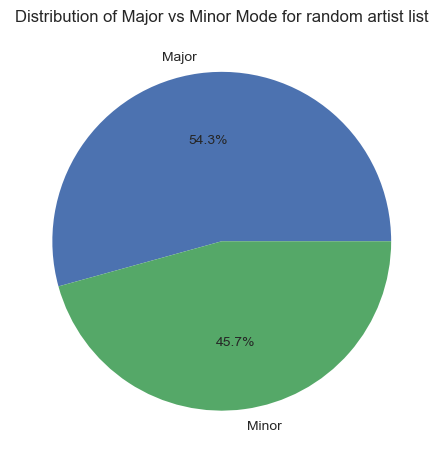

In [42]:
from matplotlib import pyplot as plt


mode_counts = songs_11k['mode'].value_counts()

# Extract the values and labels for the pie chart
values = mode_counts.values
labels = ['Major', 'Minor']

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Distribution of Major vs Minor Mode for random artist list')

# Display the chart
plt.show()

In [43]:
px.box(data_frame=songs_lastfmlist,y='track_popularity',color='key',title='Popularity by Key for Lastfmlist')


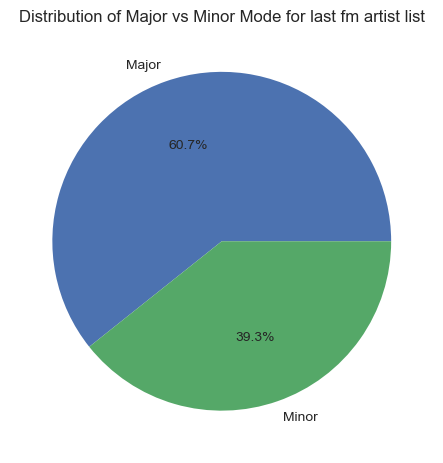

In [44]:
mode_counts = songs_lastfmlist['mode'].value_counts()

# Extract the values and labels for the pie chart
values = mode_counts.values
labels = ['Major', 'Minor']

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Distribution of Major vs Minor Mode for last fm artist list')

# Display the chart
plt.show()

We can see the statistical summary of the variables for "RANDOM ARTIST LIST, we can see the 
-highest track popularity in the dataset is 93 out of 100, 
-danceablity, energy, speechiness, valence, acousticness,instrumentalness and liveness is measured out of 1,
-altough the key is a categorical variable , the track lack loudness as spotify's standard master volume is -14 LUFs,


In [45]:
songs_11k.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
track_popularity,3109.0,40.093278,20.422571,0.000000,24.0000,40.0000,56.000000,93.000
danceability,3109.0,0.611531,0.143800,0.065100,0.5200,0.6290,0.714000,0.956
energy,3109.0,0.583931,0.185070,0.009730,0.4560,0.6040,0.724000,0.959
key,3109.0,5.164362,3.587884,0.000000,2.0000,5.0000,8.000000,11.000
loudness,3109.0,-7.332810,2.760329,-32.650000,-8.5230,-6.9550,-5.464000,-1.248
mode,3109.0,0.542940,0.498233,0.000000,0.0000,1.0000,1.000000,1.000
speechiness,3109.0,0.107960,0.111178,0.022800,0.0382,0.0593,0.119000,0.898
acousticness,3109.0,0.283756,0.285066,0.000004,0.0430,0.1660,0.480000,0.989
instrumentalness,3109.0,0.017283,0.107200,0.000000,0.0000,0.0000,0.000037,0.994
liveness,3109.0,0.202962,0.172441,0.024800,0.1000,0.1280,0.263000,0.979


In [46]:
songs_lastfmlist.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
track_popularity,3238.0,69.870908,15.448401,9.000000,62.0000,73.000000,82.00000,99.000
danceability,3237.0,0.619089,0.151514,0.094600,0.5240,0.630000,0.72700,0.971
energy,3237.0,0.635078,0.183332,0.016700,0.5250,0.650000,0.77000,0.989
key,3237.0,5.261353,3.624226,0.000000,2.0000,5.000000,8.00000,11.000
loudness,3237.0,-6.938271,2.902529,-27.372000,-8.2260,-6.374000,-4.98700,-0.173
mode,3237.0,0.607044,0.488483,0.000000,0.0000,1.000000,1.00000,1.000
speechiness,3237.0,0.095629,0.094517,0.022400,0.0365,0.053400,0.10600,0.629
acousticness,3237.0,0.230637,0.265062,0.000002,0.0246,0.118000,0.35300,0.992
instrumentalness,3237.0,0.054090,0.177008,0.000000,0.0000,0.000008,0.00125,0.987
liveness,3237.0,0.191727,0.149835,0.021000,0.1000,0.129000,0.23700,0.984


From all three Boxplots by key & The statistical measures of both the datasets, we can see that the artists list from "last.fm" has averagely 29 higher popularity, better Q1 than Random Artist data and less standard eviation which mesans consistently higher popularity  

In [47]:
songs_11k.isnull().sum()

artist              0
album               0
track_name          0
track_id            0
track_popularity    0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

In [48]:
songs_lastfmlist.isnull().sum()

track_popularity    0
track_name          0
track_id            0
danceability        1
energy              1
key                 1
loudness            1
mode                1
speechiness         1
acousticness        1
instrumentalness    1
liveness            1
valence             1
tempo               1
type                1
id                  1
uri                 1
track_href          1
analysis_url        1
duration_ms         1
time_signature      1
dtype: int64

## Visual Analysis

In [49]:
from sklearn import preprocessing

feat_cols = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

mean_vals = pd.DataFrame(columns=feat_cols)
mean_vals = mean_vals.append(songs_11k[feat_cols].mean(), ignore_index=True)
mean_vals = mean_vals.append(songs_lastfmlist[feat_cols].mean(), ignore_index=True)

print(mean_vals)

import plotly.graph_objects as go
import plotly.offline as pyo
fig = go.Figure(
    data=[
        go.Scatterpolar(r=mean_vals.iloc[0], theta=feat_cols, fill='toself', name='Random Aritist list'),
        go.Scatterpolar(r=mean_vals.iloc[1], theta=feat_cols, fill='toself', name='Lastfm_artist list'),
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Feature comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

#pyo.plot(fig)
fig.show()

   danceability    energy  speechiness  acousticness  instrumentalness  \
0      0.611531  0.583931     0.107960      0.283756          0.017283   
1      0.619089  0.635078     0.095629      0.230637          0.054090   

   liveness   valence  
0  0.202962  0.414228  
1  0.191727  0.475752  


C:\Users\yjain\AppData\Local\Temp\ipykernel_3080\2559114456.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yjain\AppData\Local\Temp\ipykernel_3080\2559114456.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



The chart above shows that "Random Artist list" tracks have less energy & more acousticness in comparison to lastfm Artitst List, it also suggests why there is slight lack in acousticness but higher Valence('Good vibes') & Energy. There is room for improvement in terms of mastering and mixing the song to match the professional output

Now we analyze different features against others

In [50]:
num_df_11k = songs_11k.select_dtypes(include = 'number')

In [51]:
num_df_lastfm = songs_lastfmlist.select_dtypes(include = 'number')

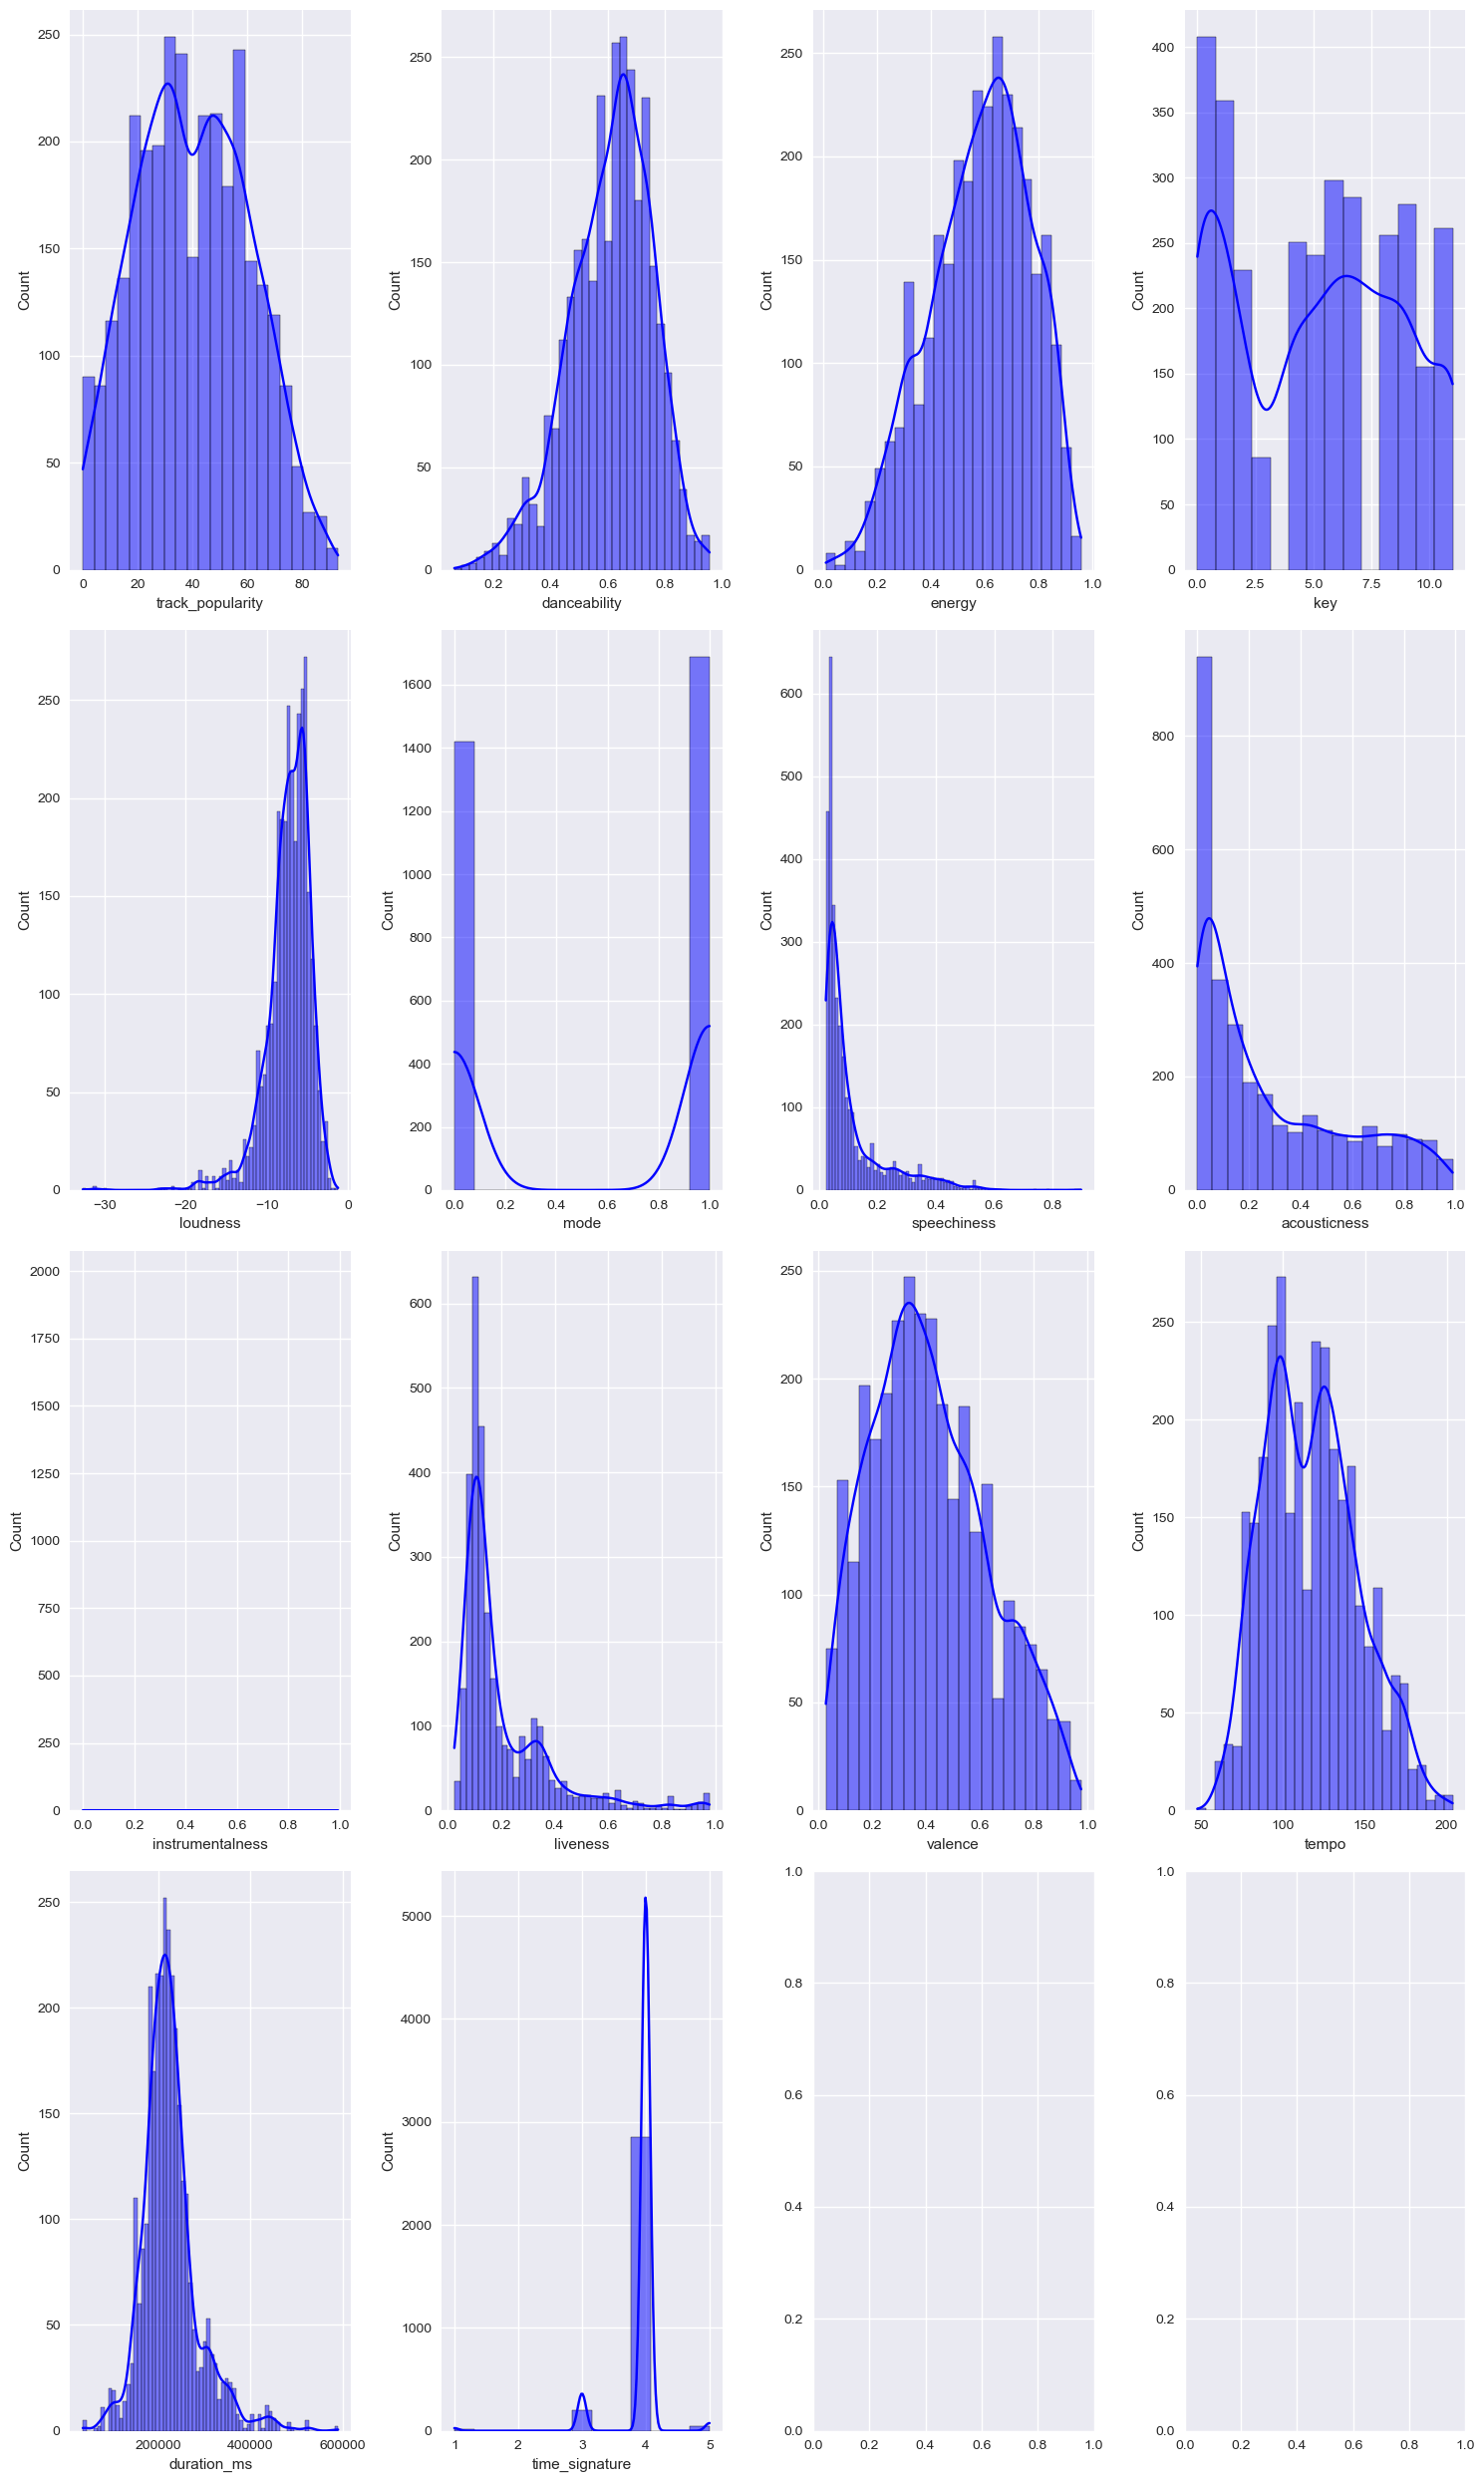

In [52]:
plt.style.use('seaborn')

names = list(num_df_11k.columns)

plot_per_row = 4

f, axes = plt.subplots(round(len(names)/plot_per_row), plot_per_row, figsize = (15, 25))

y = 0;

for name in names:
    i, j = divmod(y, plot_per_row)
    sns.histplot(x=num_df_11k[name], kde = True, ax=axes[i, j], color = 'blue')
    y = y + 1

plt.tight_layout()
plt.show()


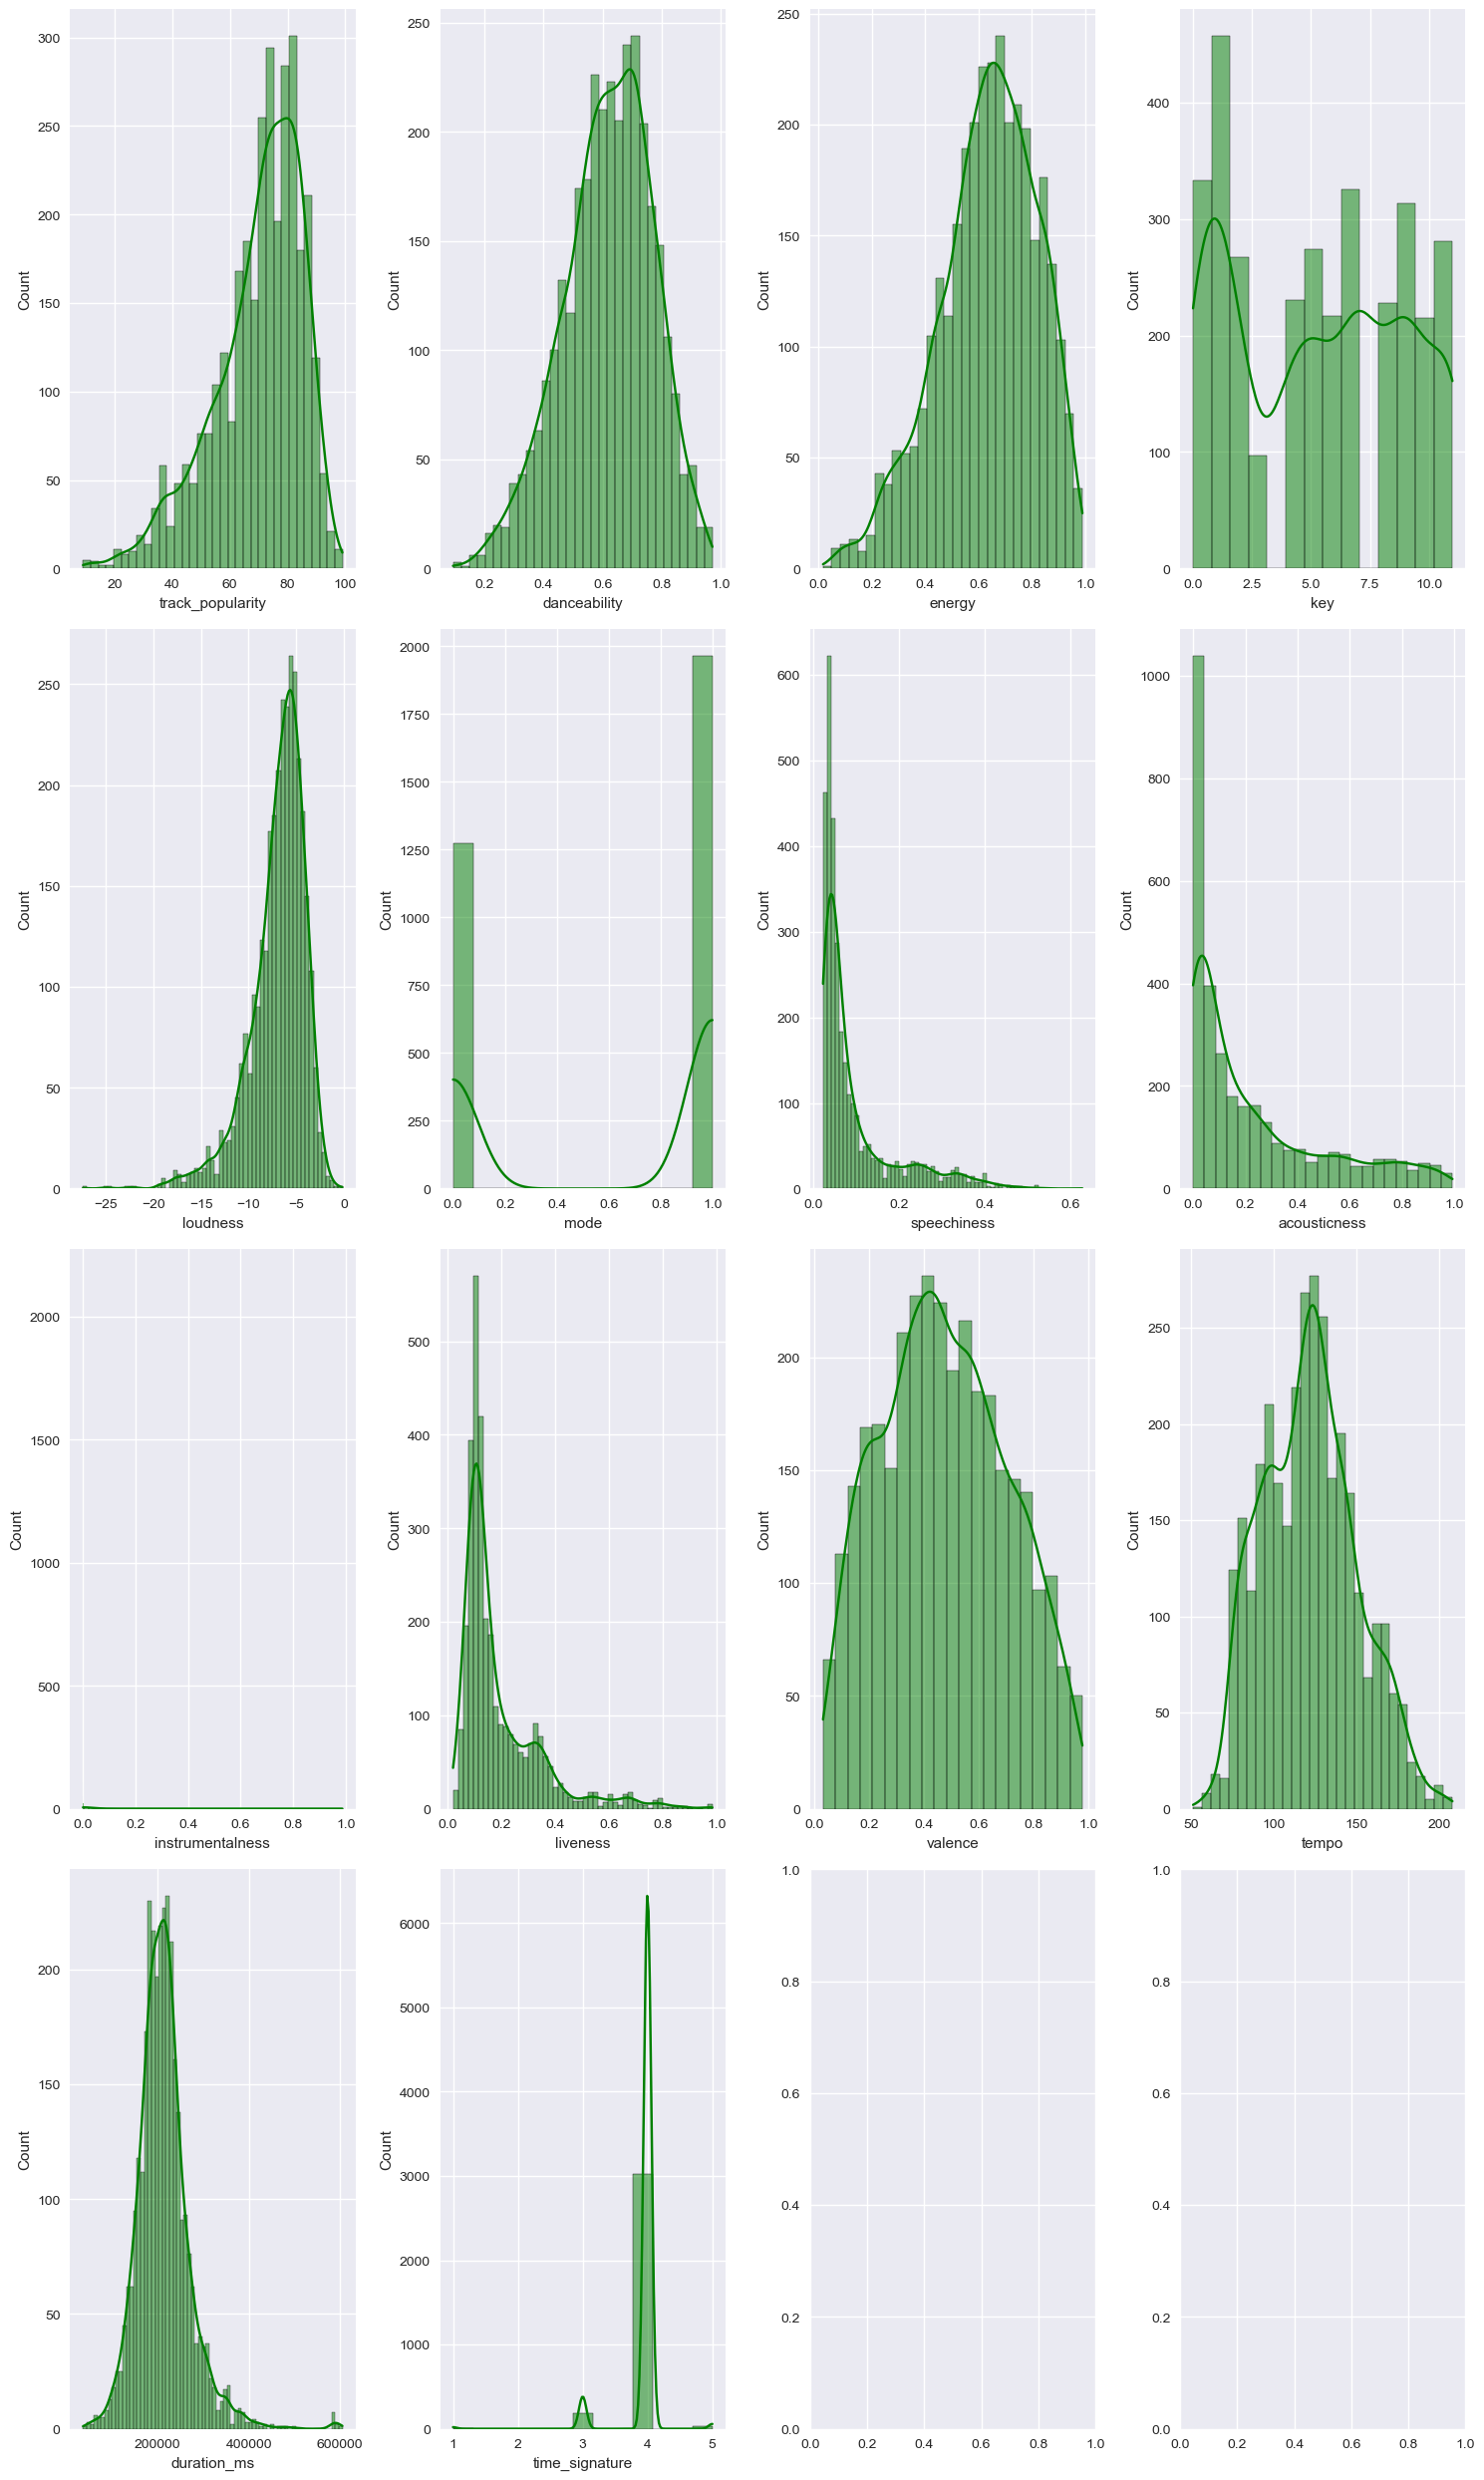

In [53]:
plt.style.use('seaborn')

names = list(num_df_lastfm.columns)

plot_per_row = 4

f, axes = plt.subplots(round(len(names)/plot_per_row), plot_per_row, figsize = (15, 25))

y = 0;

for name in names:
    i, j = divmod(y, plot_per_row)
    sns.histplot(x=num_df_lastfm[name], kde = True, ax=axes[i, j], color = 'Green')
    y = y + 1

plt.tight_layout()
plt.show()


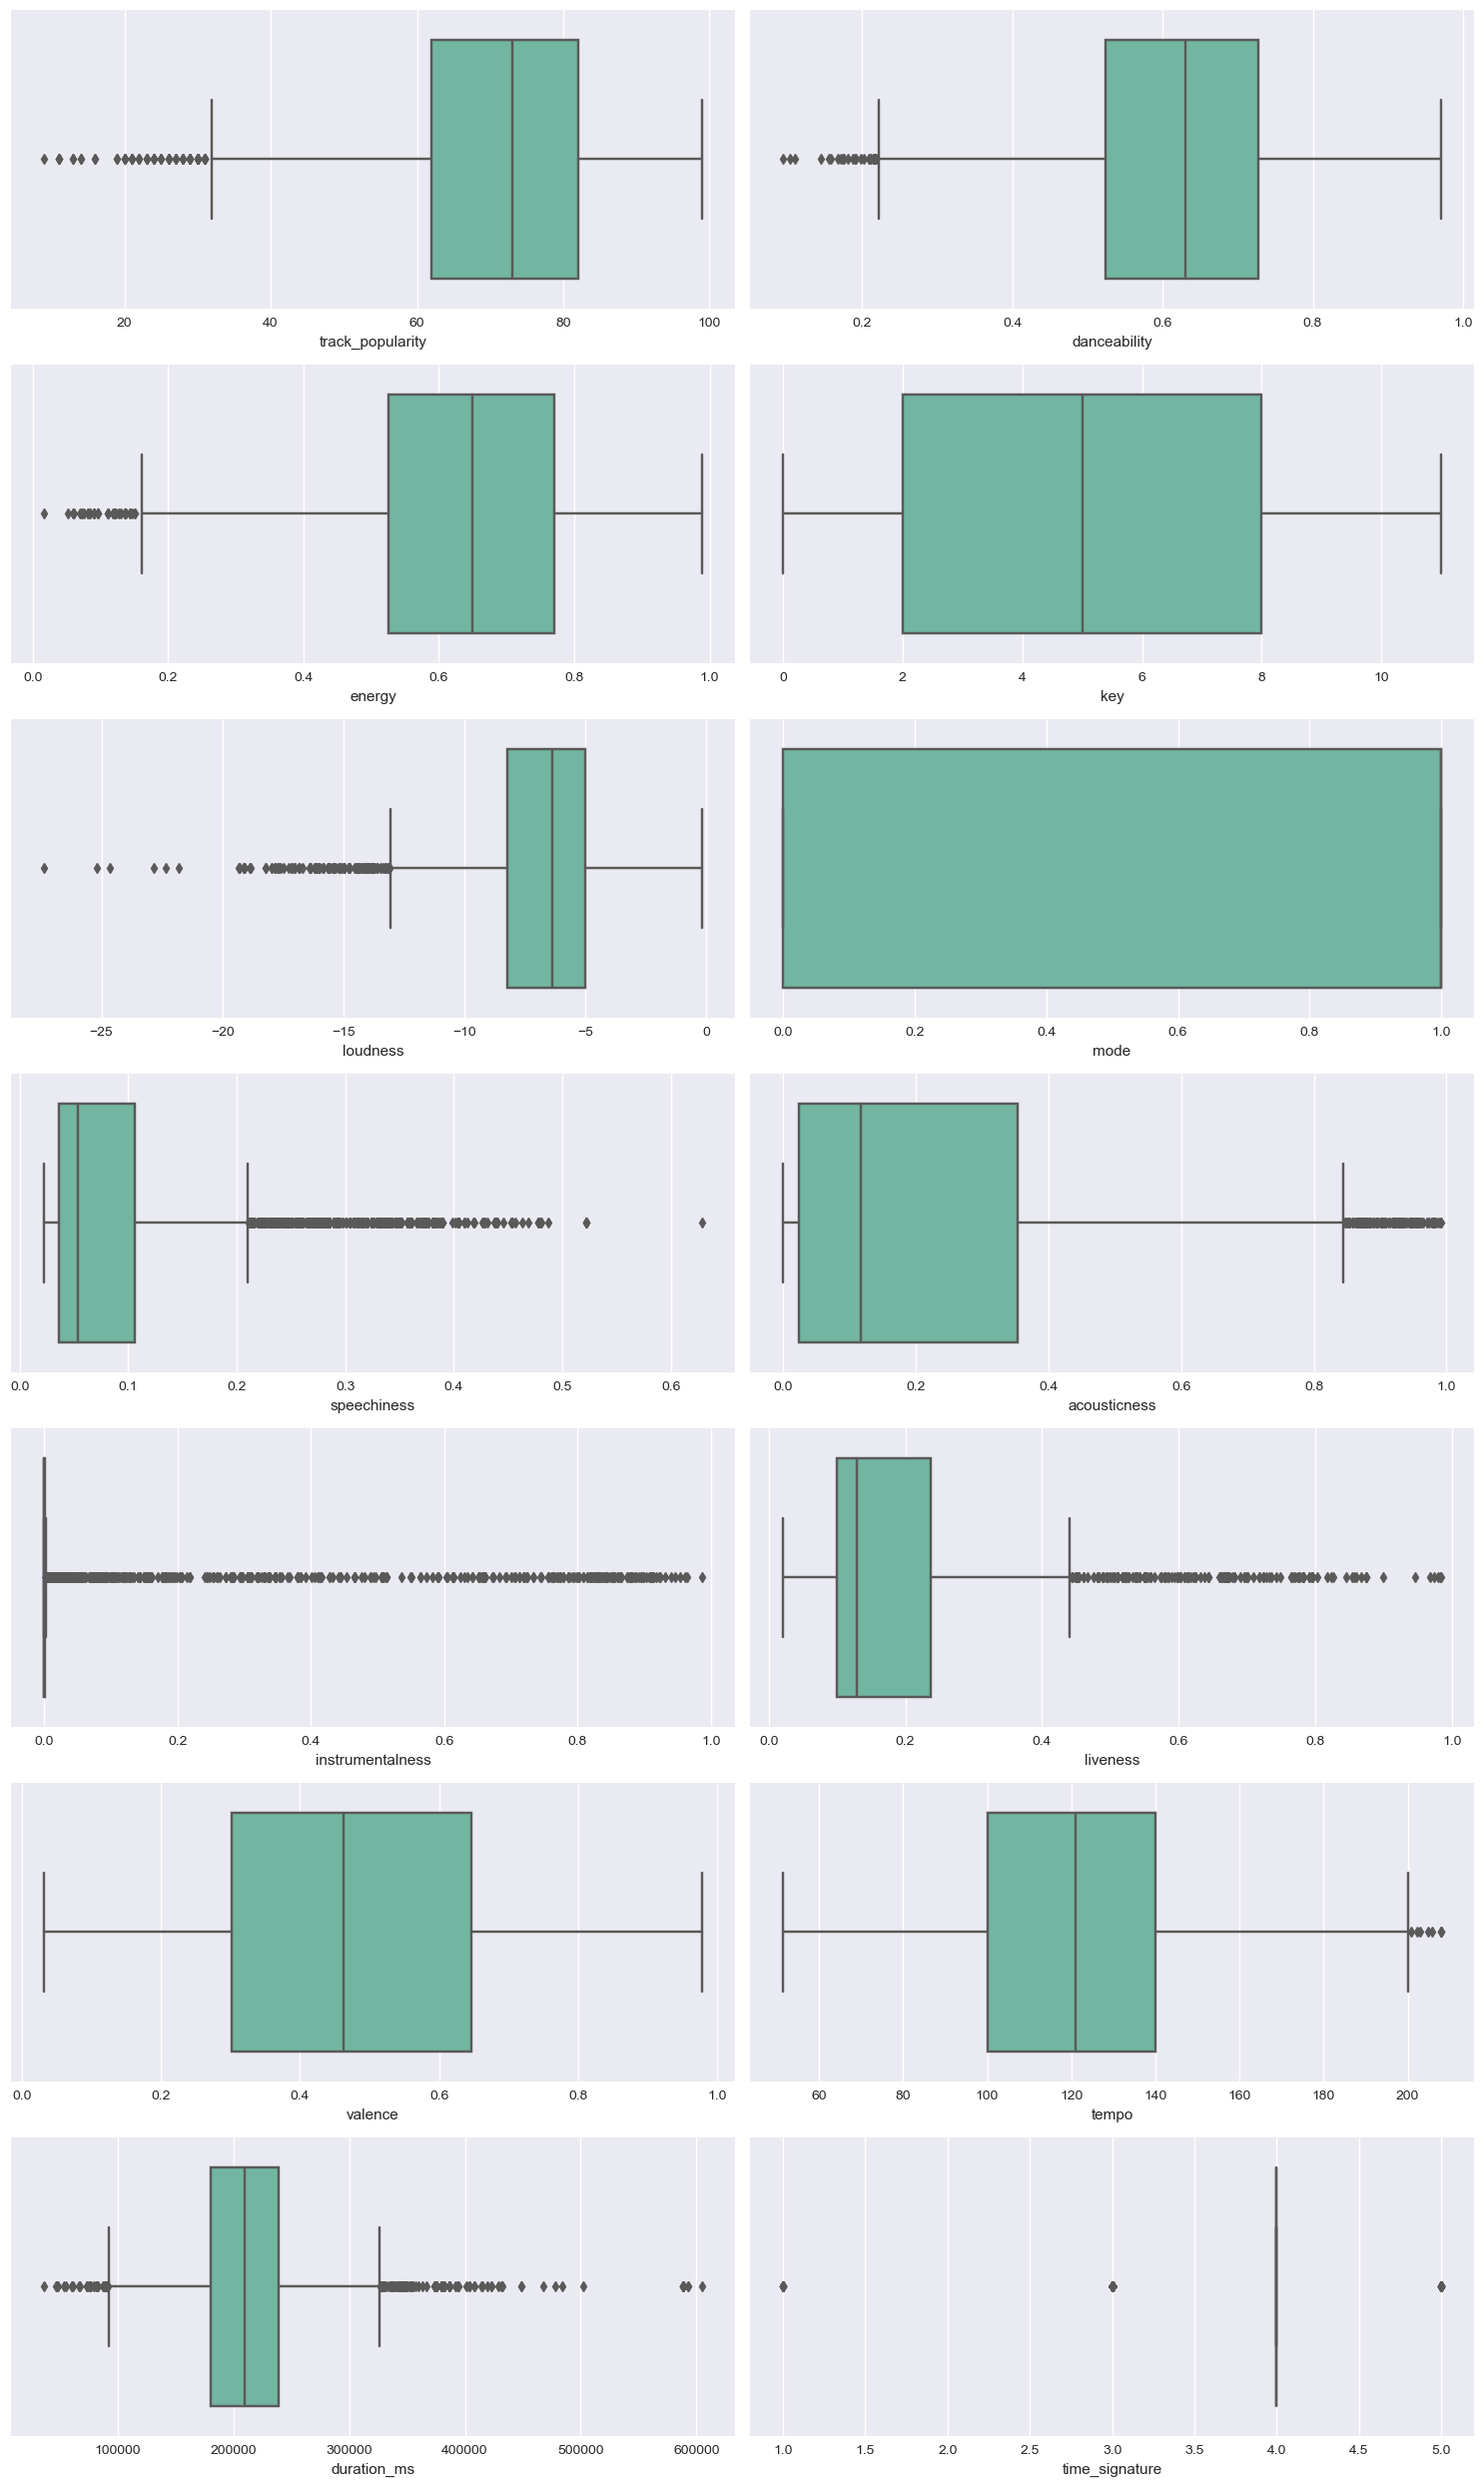

In [55]:
plt.style.use('seaborn')

names = list(num_df_lastfm.columns)

plot_per_row = 2

f, axes = plt.subplots(round(len(names)/plot_per_row), plot_per_row, figsize = (15, 25))

y = 0;

for name in names:
    i, j = divmod(y, plot_per_row)
    sns.boxplot(x=num_df_lastfm[name], ax=axes[i, j], palette = 'Set2')
    y = y + 1

plt.tight_layout()
plt.show()


### Feature Correlation Analysis

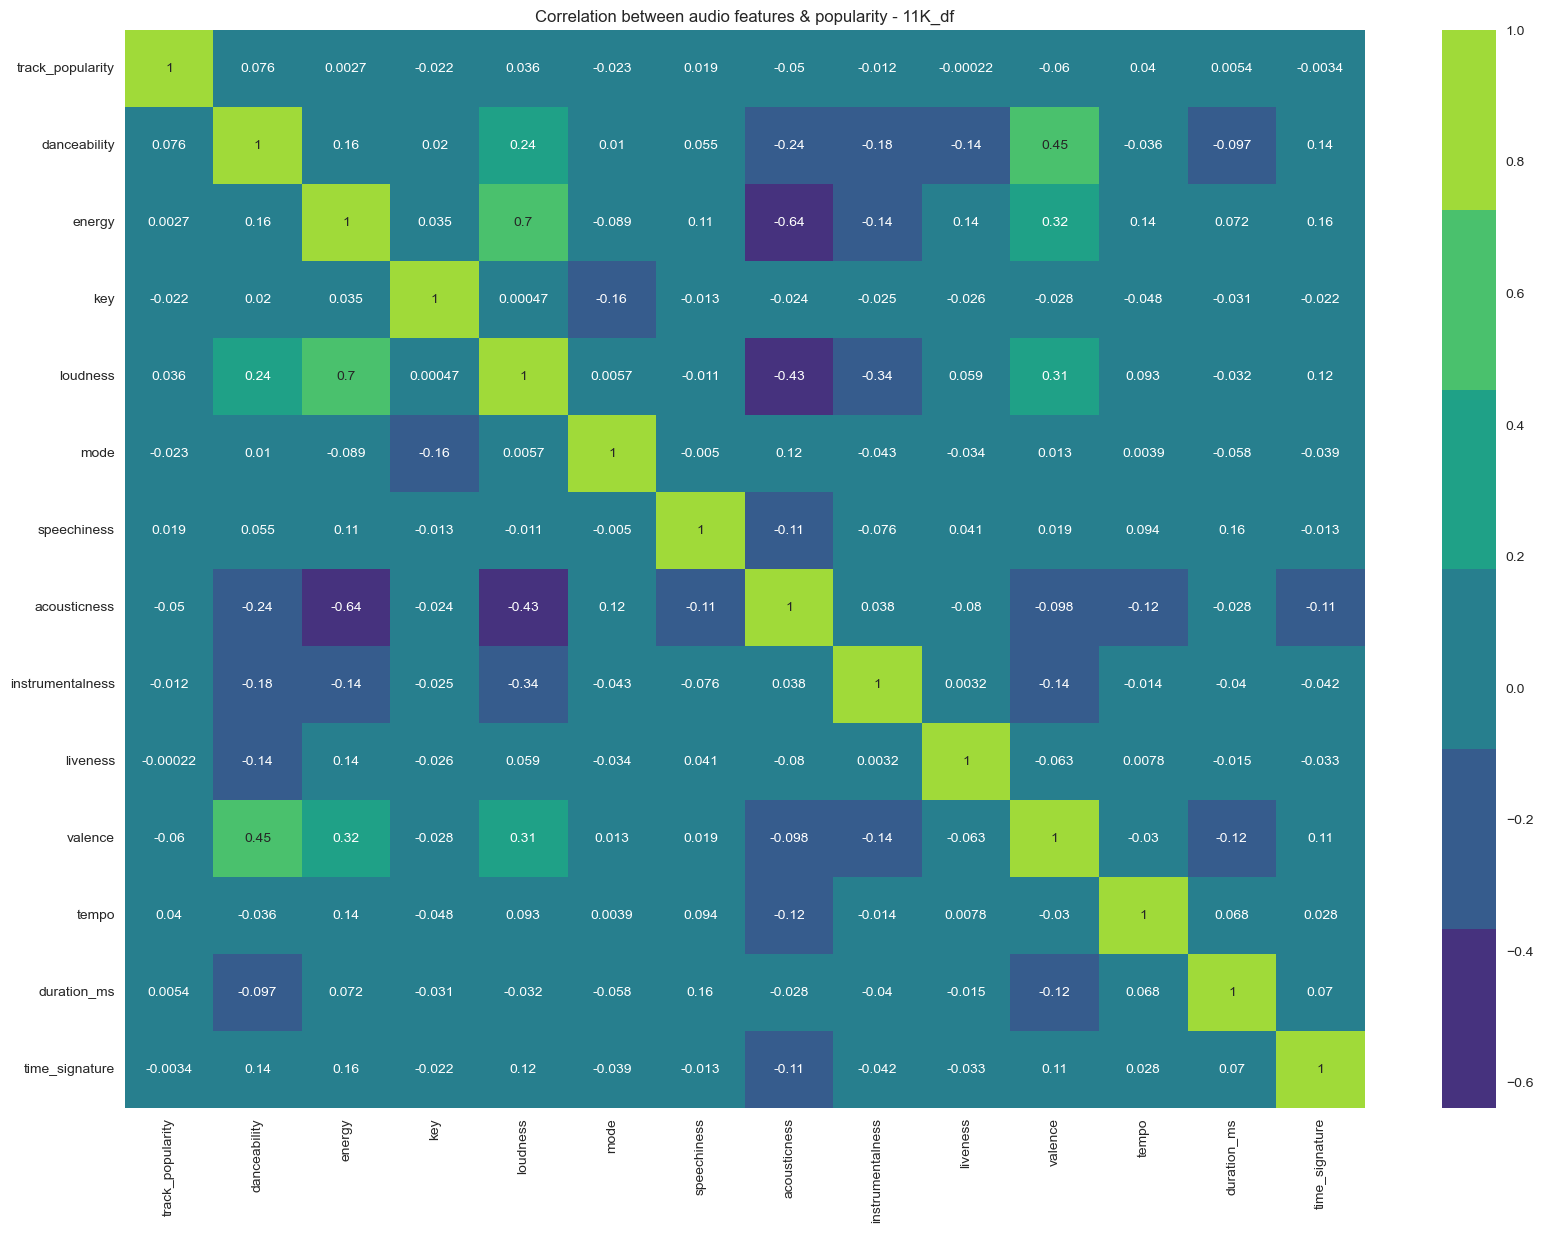

track_popularity    1.000000
danceability        0.076100
tempo               0.040092
loudness            0.035961
speechiness         0.019269
duration_ms         0.005376
energy              0.002710
liveness           -0.000219
time_signature     -0.003428
instrumentalness   -0.012000
key                -0.022389
mode               -0.023351
acousticness       -0.049855
valence            -0.059672
Name: track_popularity, dtype: float64

In [56]:
plt.figure(figsize = (20, 14))

corr_matrix = num_df_11k.corr()
cmap = sns.color_palette('viridis')
sns.heatmap(corr_matrix, annot = True, cmap = cmap)
plt.title('Correlation between audio features & popularity - 11K_df')
plt.show()

corr_matrix["track_popularity"].sort_values(ascending=False)

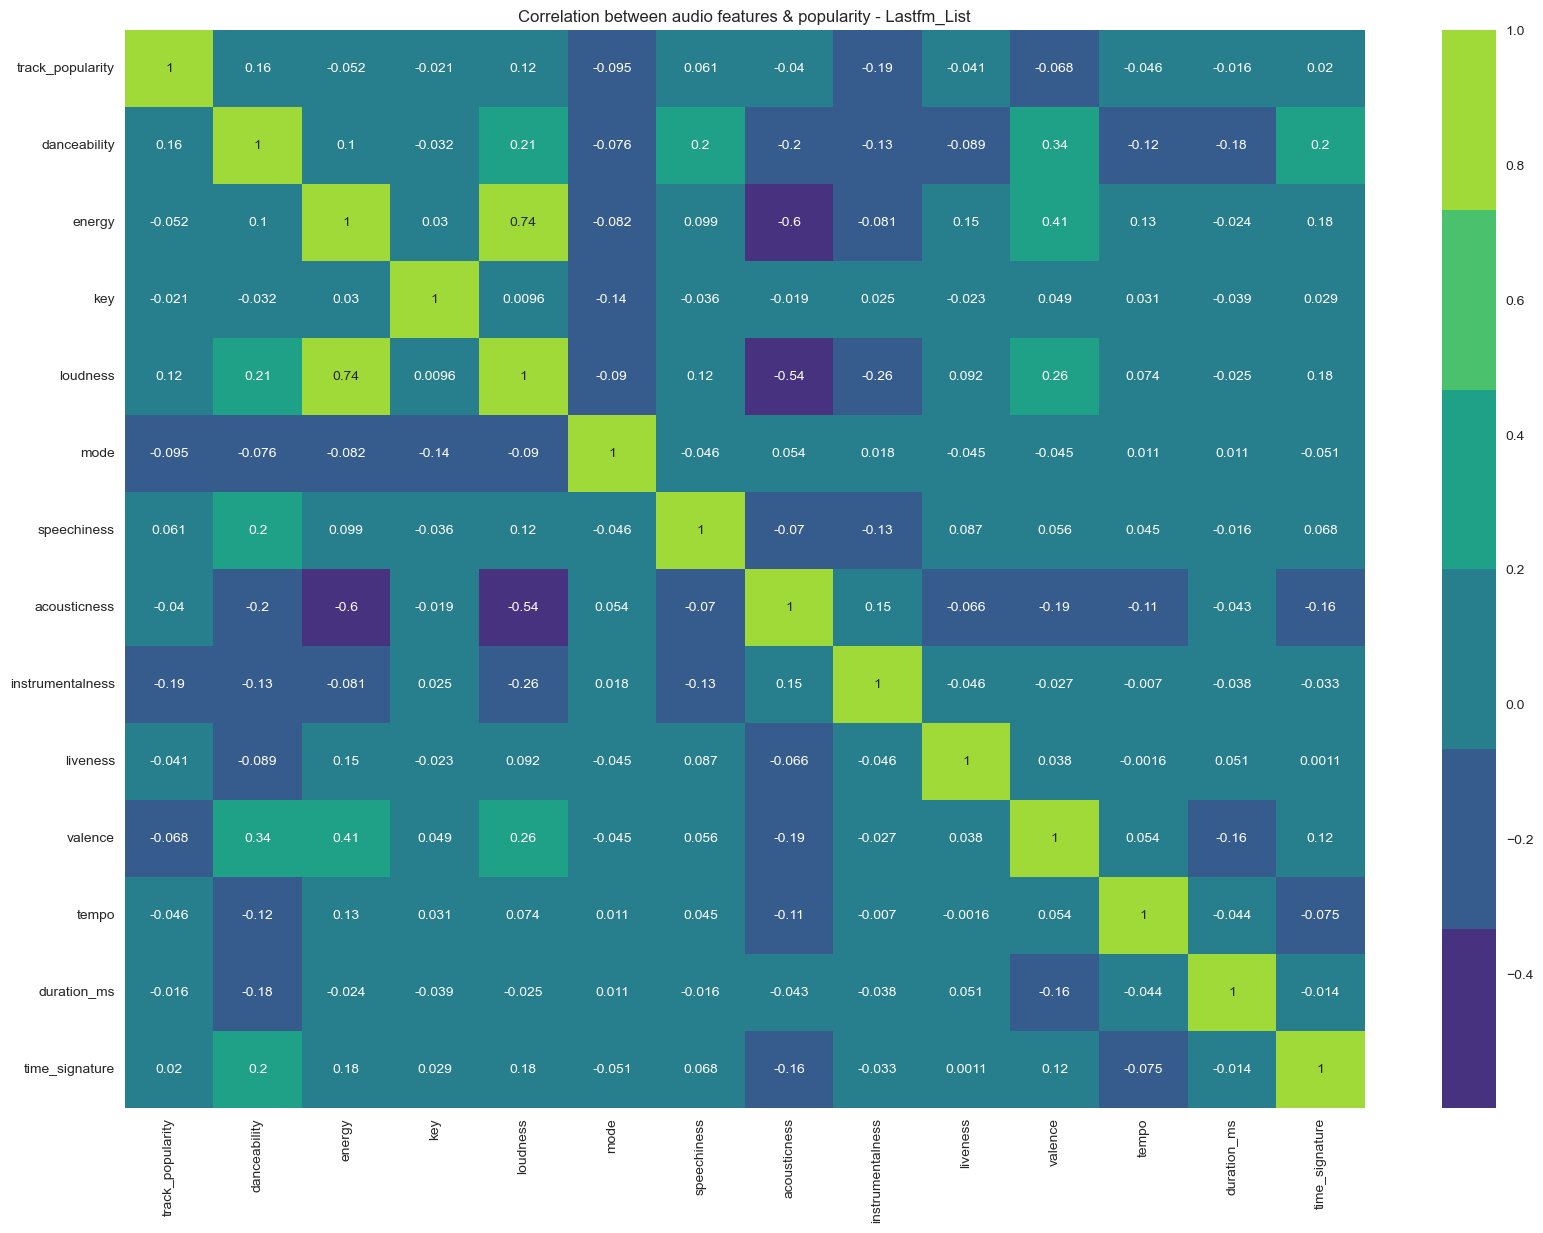

track_popularity    1.000000
danceability        0.155709
loudness            0.118426
speechiness         0.060809
time_signature      0.020354
duration_ms        -0.016180
key                -0.021357
acousticness       -0.039942
liveness           -0.041334
tempo              -0.046435
energy             -0.052116
valence            -0.067586
mode               -0.094885
instrumentalness   -0.186649
Name: track_popularity, dtype: float64

In [57]:
plt.figure(figsize = (20, 14))

corr_matrix = num_df_lastfm.corr()
cmap = sns.color_palette('viridis')
sns.heatmap(corr_matrix, annot = True, cmap = cmap)
plt.title('Correlation between audio features & popularity - Lastfm_List')
plt.show()

corr_matrix["track_popularity"].sort_values(ascending=False)

In [58]:
total = num_df_11k.shape[0]
popularity_score_more_than_40 = num_df_11k[num_df_11k['track_popularity'] > 50].shape[0]

probability = (popularity_score_more_than_40/total)*100
print("Probability of song getting more than 40 in popularity for random artist data :", probability)

Probability of song getting more than 40 in popularity for random artist data : 32.61498874236089


In [59]:
total = num_df_lastfm.shape[0]
popularity_score_more_than_40 = num_df_lastfm[num_df_lastfm['track_popularity'] > 50].shape[0]

probability = (popularity_score_more_than_40/total)*100
print("Probability of song getting more than 40 in popularity for lastfm artist data :", probability)

Probability of song getting more than 40 in popularity for lastfm artist data : 87.83199505867819


# Analyzing Top 4 Correlated Audio Features

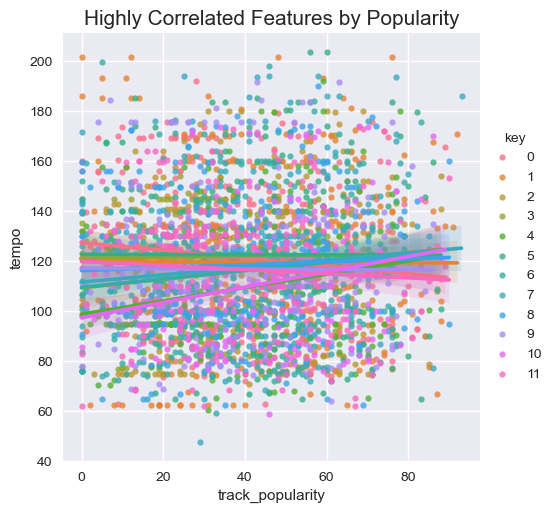

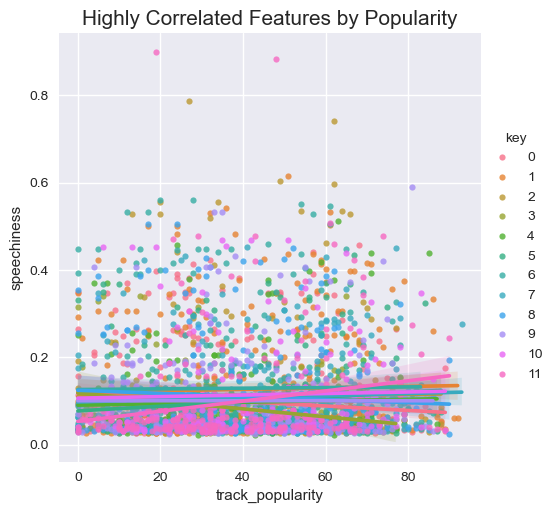

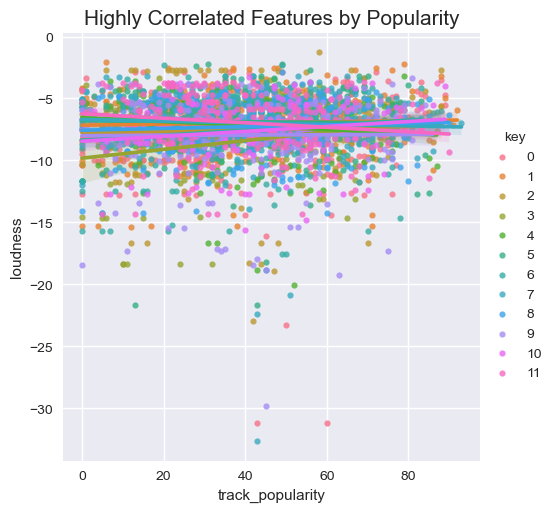

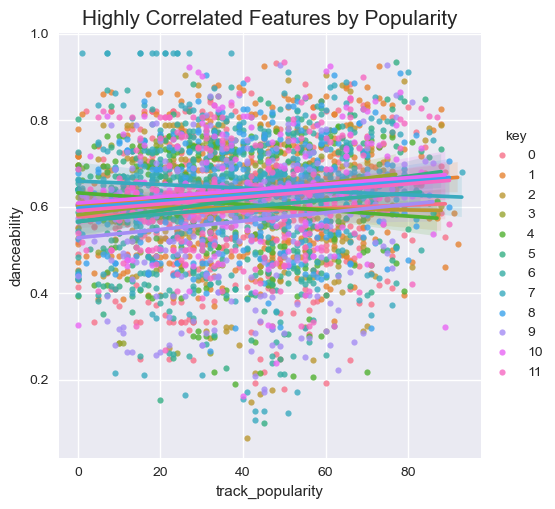

In [60]:
# List of columns for which you want to create scatter plots
columns_to_plot = ["tempo", "speechiness", "loudness", "danceability"]

for col in columns_to_plot:
    plot = sns.lmplot(
        x="track_popularity",
        y=col,
        data=num_df_11k,
        hue='key',
        scatter_kws={'s': 20},  # Adjust the '10' as needed for scaling
    )
    plt.title('Highly Correlated Features by Popularity', fontsize=15)
    plt.show()


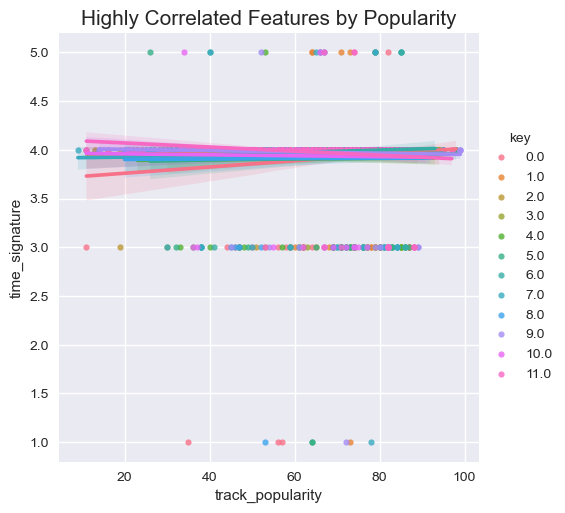

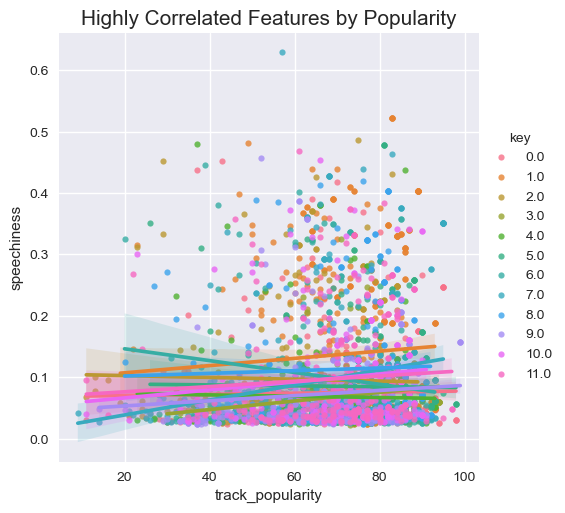

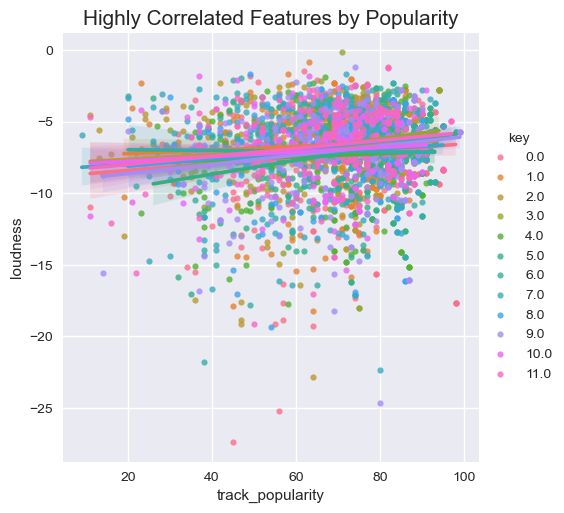

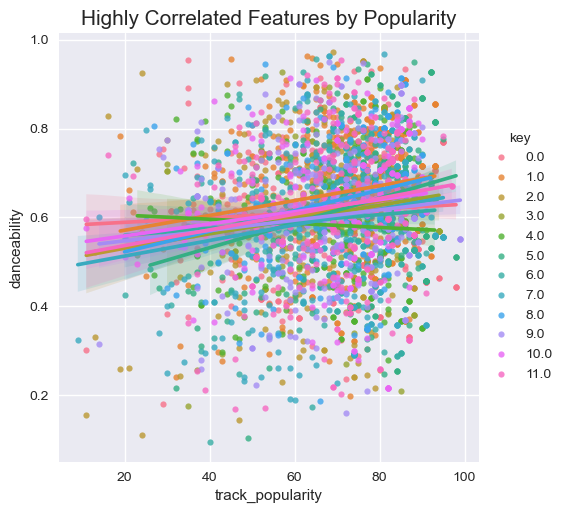

In [61]:

# List of columns for which you want to create scatter plots
columns_to_plot = ["time_signature","speechiness","loudness","danceability"]

for col in columns_to_plot:
    plot = sns.lmplot(
        x="track_popularity",
        y=col,
        data=num_df_lastfm,
        hue='key',
        scatter_kws={'s': 20},  # Adjust the '10' as needed for scaling
    )
    plt.title('Highly Correlated Features by Popularity', fontsize=15)
    plt.show()


In [63]:
combined_df.dropna(inplace=True)

combined_df = combined_df[combined_df['track_popularity'] > 10]

combined_df.reset_index(drop=True, inplace=True)

combined_df.isnull().sum()

artist              0
album               0
track_name          0
track_id            0
track_popularity    0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

In [64]:
# Drop rows with NaN or null values
songs_11k.dropna(inplace=True)

# Filter the DataFrame to keep tracks with popularity higher than 10
songs_11k = songs_11k[songs_11k['track_popularity'] > 10]

# Reset the index after filtering
songs_11k.reset_index(drop=True, inplace=True)

songs_11k.isnull().sum()

artist              0
album               0
track_name          0
track_id            0
track_popularity    0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

In [65]:
songs_lastfmlist.dropna(inplace=True)

songs_lastfmlist = songs_lastfmlist[songs_lastfmlist['track_popularity'] > 10]

# Reset the index after filtering
songs_lastfmlist.reset_index(drop=True, inplace=True)

songs_lastfmlist.isnull().sum()

track_popularity    0
track_name          0
track_id            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

# Dropping Irrelevant Features 

In [137]:
to_drop = ['artist','album','track_name','track_id','type','id','uri','track_href','analysis_url']

# MODELING WITH COMBINED DATASET

In [138]:
tracks_modified =combined_df.drop(labels = to_drop,axis =1)

In [139]:

def evaluate_linear_regression(X_train, y_train, X_test, y_test):
    # Create and train the linear regression model
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    # Print the summary of the linear regression model
    print(results.summary())

    # Add a constant (intercept) to the test feature matrix
    X_test = sm.add_constant(X_test)

    # Evaluate the model on the test set
    y_pred = results.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, y_pred, results

def visualize_predictions_lr(y_test, y_pred):
    visualizer_lr = PredictionError(lr_model)
    visualizer_lr.fit(X_train, y_train)
    visualizer_lr.score(X_test, y_test)
    visualizer_lr.poof()

def evaluate_random_forest(X_train, y_train, X_test, y_test):
    # Create and train the Random Forest Regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred_rf = rf_model.predict(X_test)

    # Calculate evaluation metrics
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    return mse_rf, r2_rf, y_pred_rf, rf_model

def visualize_predictions(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')  # Actual values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values")
    plt.legend()
    plt.show()


def evaluate_gradient_boosting(X_train, y_train, X_test, y_test):
    # Create a Gradient Boosting Regressor model
    gb_model = GradientBoostingRegressor(random_state=42)

    # Fit the model to your training data
    gb_model.fit(X_train, y_train)

    # Predict using the test data
    gb_y_pred = gb_model.predict(X_test)

    # Evaluate the model using MSE and R-squared
    gb_mse = mean_squared_error(y_test, gb_y_pred)
    gb_r2 = r2_score(y_test, gb_y_pred)

    return gb_mse, gb_r2, gb_y_pred, gb_model

def visualize_predictions_gb(y_test, gb_y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, gb_y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')  # Actual values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values (Gradient Boosting Regressor)")
    plt.legend()
    plt.show()
    

def evaluate_decision_tree(X_train, y_train, X_test, y_test):
    # Create a Decision Tree Regressor model
    dt_model = DecisionTreeRegressor(random_state=42)

    # Fit the model to your training data
    dt_model.fit(X_train, y_train)

    # Predict using the test data
    dt_y_pred = dt_model.predict(X_test)

    # Evaluate the model using MSE and R-squared
    dt_mse = mean_squared_error(y_test, dt_y_pred)
    dt_r2 = r2_score(y_test, dt_y_pred)

    return dt_mse, dt_r2, dt_y_pred, dt_model

def visualize_predictions_dt(y_test, dt_y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, dt_y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')  # Actual values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values (Decision Tree Regressor)")
    plt.legend()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.162
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           3.83e-09
Time:                        03:33:53   Log-Likelihood:                -9960.5
No. Observations:                2301   AIC:                         1.995e+04
Df Residuals:                    2287   BIC:                         2.003e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               45.1565      6.593  

C:\Users\yjain\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



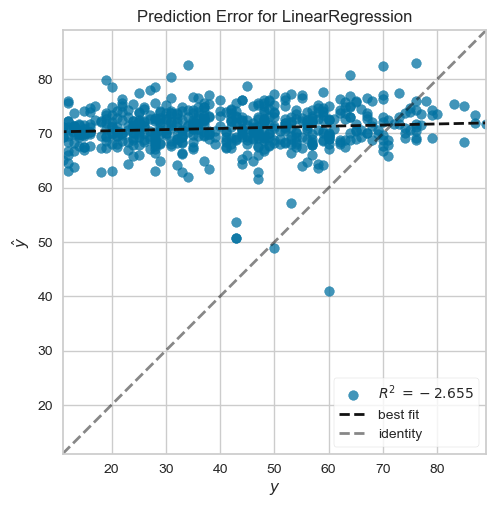

In [140]:
# Split the dataset into training and testing sets (first part)
X_train, X_test, y_train, y_test = train_test_split(
    tracks_modified.drop('track_popularity', axis=1),
    tracks_modified['track_popularity'],
    test_size=0.2,
    random_state=42
)

# Train and evaluate the linear regression model (first part)
mse, r2, y_pred, results = evaluate_linear_regression(X_train, y_train, X_test, y_test)

# Print evaluation metrics (first part)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize predictions and residuals (second part)
visualize_predictions_lr(y_test, y_pred)


Random Forest Regression - Mean Squared Error: 374.96960905502414
Random Forest Regression - R-squared: -0.15450282724981212


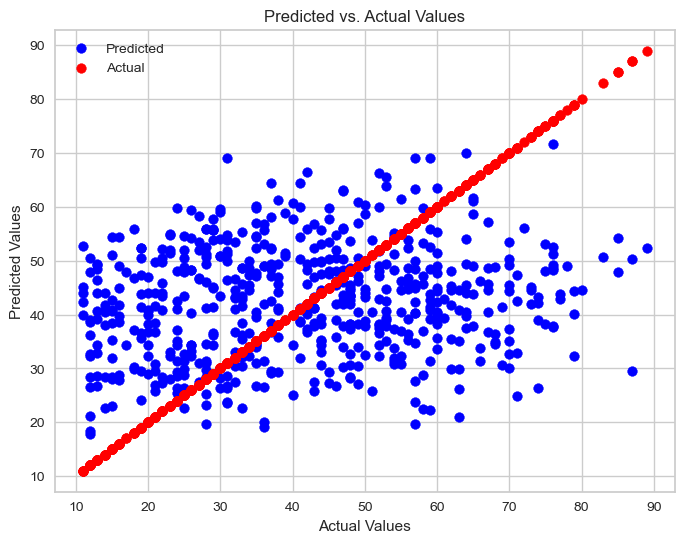

In [141]:
# Train and evaluate the Random Forest Regressor model
mse_rf, r2_rf, y_pred_rf, rf_model = evaluate_random_forest(X_train, y_train, X_test, y_test)

# Print evaluation metrics
print("Random Forest Regression - Mean Squared Error:", mse_rf)
print("Random Forest Regression - R-squared:", r2_rf)

# Visualize predictions and residuals
visualize_predictions(y_test, y_pred_rf)



Gradient Boosting Regression - Mean Squared Error: 325.43605145647575
Gradient Boosting Regression - R-squared: -0.0019927813413349593


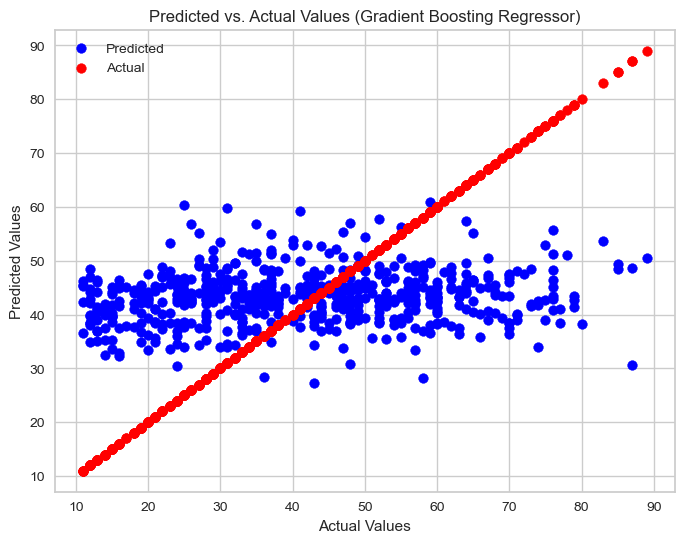

In [142]:


# Train and evaluate the Gradient Boosting Regressor model
gb_mse, gb_r2, gb_y_pred, gb_model = evaluate_gradient_boosting(X_train, y_train, X_test, y_test)

# Print evaluation metrics
print("Gradient Boosting Regression - Mean Squared Error:", gb_mse)
print("Gradient Boosting Regression - R-squared:", gb_r2)

# Visualize predictions and residuals
visualize_predictions_gb(y_test, gb_y_pred)


Decision Tree Regression - Mean Squared Error: 551.3208020335888
Decision Tree Regression - R-squared: -0.6974747000789876


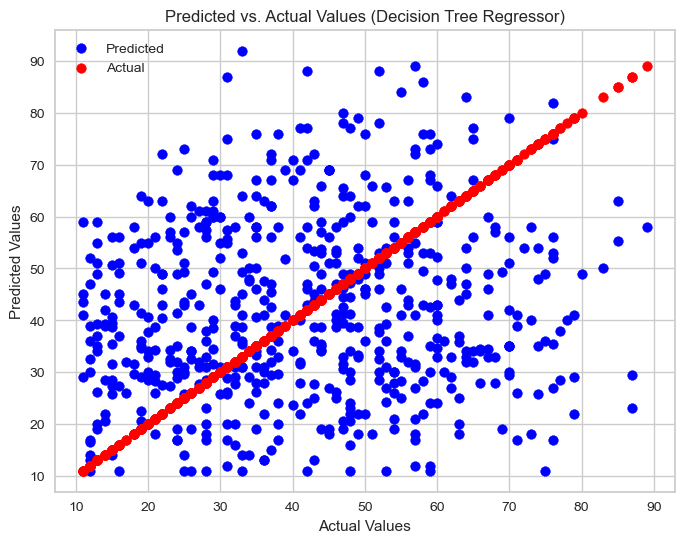

In [143]:



# Train and evaluate the Decision Tree Regressor model
dt_mse, dt_r2, dt_y_pred, dt_model = evaluate_decision_tree(X_train, y_train, X_test, y_test)

# Print evaluation metrics
print("Decision Tree Regression - Mean Squared Error:", dt_mse)
print("Decision Tree Regression - R-squared:", dt_r2)

# Visualize predictions and residuals
visualize_predictions_dt(y_test, dt_y_pred)


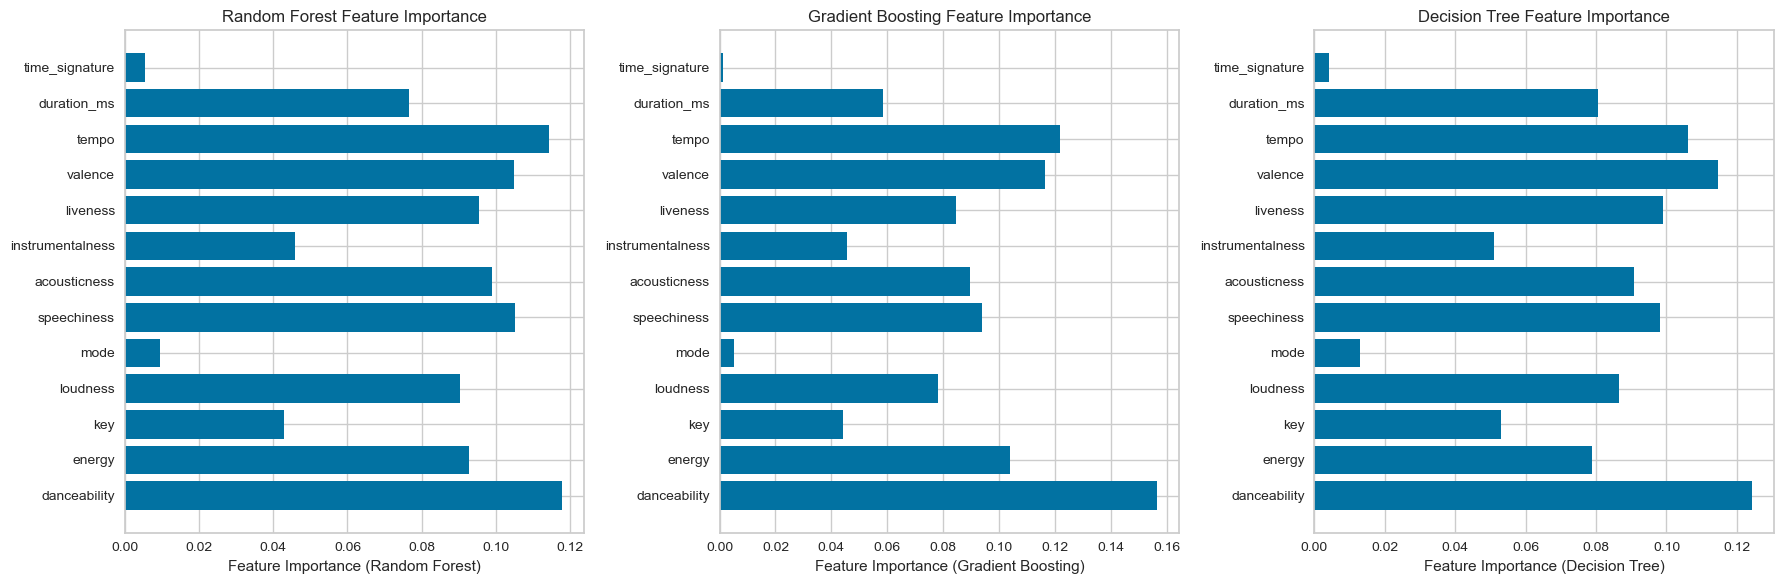

In [144]:

# Get feature importances from the models
rf_feature_importances = rf_model.feature_importances_
gb_feature_importances = gb_model.feature_importances_
dt_feature_importances = dt_model.feature_importances_

feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                 'duration_ms', 'time_signature']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot Random Forest feature importances
axes[0].barh(feature_names, rf_feature_importances)
axes[0].set_xlabel('Feature Importance (Random Forest)')
axes[0].set_title('Random Forest Feature Importance')

# Plot Gradient Boosting feature importances
axes[1].barh(feature_names, gb_feature_importances)
axes[1].set_xlabel('Feature Importance (Gradient Boosting)')
axes[1].set_title('Gradient Boosting Feature Importance')

# Plot Decision Tree feature importances
axes[2].barh(feature_names, dt_feature_importances)
axes[2].set_xlabel('Feature Importance (Decision Tree)')
axes[2].set_title('Decision Tree Feature Importance')

plt.tight_layout()

# Show the plot
plt.show()


# MODELING WITH Random Artist List DATASET

In [145]:
tracks_modified =songs_11k.drop(labels = to_drop,axis =1)

In [146]:

def evaluate_linear_regression(X_train, y_train, X_test, y_test):
    # Create and train the linear regression model
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    # Print the summary of the linear regression model
    print(results.summary())

    # Add a constant (intercept) to the test feature matrix
    X_test = sm.add_constant(X_test)

    # Evaluate the model on the test set
    y_pred = results.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, y_pred, results

def visualize_predictions_lr(y_test, y_pred):
    visualizer_lr = PredictionError(lr_model)
    visualizer_lr.fit(X_train, y_train)
    visualizer_lr.score(X_test, y_test)
    visualizer_lr.poof()

def evaluate_random_forest(X_train, y_train, X_test, y_test):
    # Create and train the Random Forest Regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred_rf = rf_model.predict(X_test)

    # Calculate evaluation metrics
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    return mse_rf, r2_rf, y_pred_rf, rf_model

def visualize_predictions(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')  # Actual values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values")
    plt.legend()
    plt.show()


def evaluate_gradient_boosting(X_train, y_train, X_test, y_test):
    # Create a Gradient Boosting Regressor model
    gb_model = GradientBoostingRegressor(random_state=42)

    # Fit the model to your training data
    gb_model.fit(X_train, y_train)

    # Predict using the test data
    gb_y_pred = gb_model.predict(X_test)

    # Evaluate the model using MSE and R-squared
    gb_mse = mean_squared_error(y_test, gb_y_pred)
    gb_r2 = r2_score(y_test, gb_y_pred)

    return gb_mse, gb_r2, gb_y_pred, gb_model

def visualize_predictions_gb(y_test, gb_y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, gb_y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')  # Actual values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values (Gradient Boosting Regressor)")
    plt.legend()
    plt.show()
    

def evaluate_decision_tree(X_train, y_train, X_test, y_test):
    # Create a Decision Tree Regressor model
    dt_model = DecisionTreeRegressor(random_state=42)

    # Fit the model to your training data
    dt_model.fit(X_train, y_train)

    # Predict using the test data
    dt_y_pred = dt_model.predict(X_test)

    # Evaluate the model using MSE and R-squared
    dt_mse = mean_squared_error(y_test, dt_y_pred)
    dt_r2 = r2_score(y_test, dt_y_pred)

    return dt_mse, dt_r2, dt_y_pred, dt_model

def visualize_predictions_dt(y_test, dt_y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, dt_y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')  # Actual values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values (Decision Tree Regressor)")
    plt.legend()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.162
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           3.83e-09
Time:                        03:33:57   Log-Likelihood:                -9960.5
No. Observations:                2301   AIC:                         1.995e+04
Df Residuals:                    2287   BIC:                         2.003e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               45.1565      6.593  

C:\Users\yjain\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



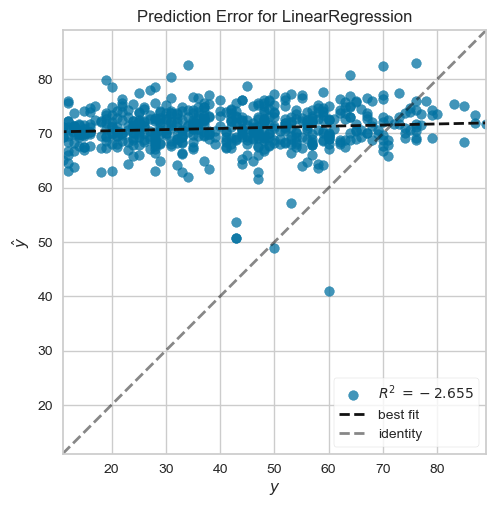

In [147]:
# Split the dataset into training and testing sets (first part)
X_train, X_test, y_train, y_test = train_test_split(
    tracks_modified.drop('track_popularity', axis=1),
    tracks_modified['track_popularity'],
    test_size=0.2,
    random_state=42
)

# Train and evaluate the linear regression model (first part)
mse, r2, y_pred, results = evaluate_linear_regression(X_train, y_train, X_test, y_test)

# Print evaluation metrics (first part)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize predictions and residuals (second part)
visualize_predictions_lr(y_test, y_pred)


Random Forest Regression - Mean Squared Error: 374.96960905502414
Random Forest Regression - R-squared: -0.15450282724981212


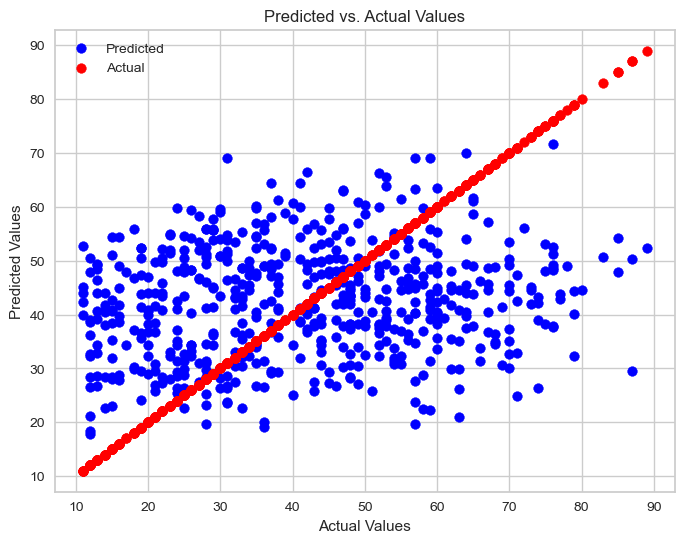

In [148]:
# Train and evaluate the Random Forest Regressor model
mse_rf, r2_rf, y_pred_rf, rf_model = evaluate_random_forest(X_train, y_train, X_test, y_test)

# Print evaluation metrics
print("Random Forest Regression - Mean Squared Error:", mse_rf)
print("Random Forest Regression - R-squared:", r2_rf)

# Visualize predictions and residuals
visualize_predictions(y_test, y_pred_rf)



Gradient Boosting Regression - Mean Squared Error: 325.43605145647575
Gradient Boosting Regression - R-squared: -0.0019927813413349593


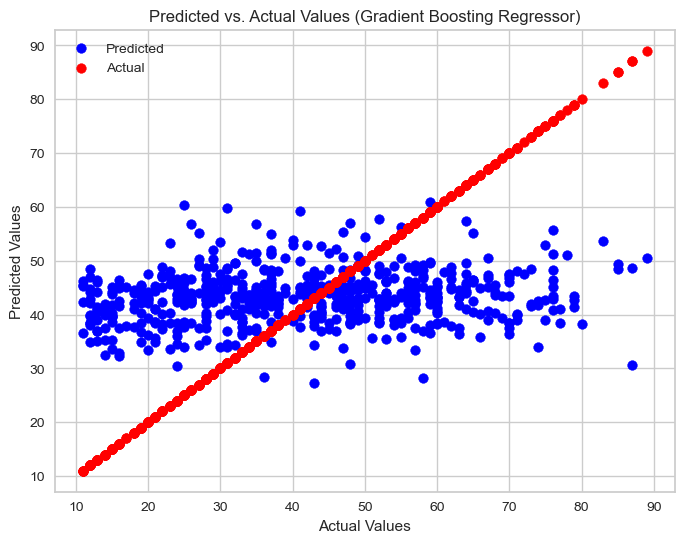

In [149]:


# Train and evaluate the Gradient Boosting Regressor model
gb_mse, gb_r2, gb_y_pred, gb_model = evaluate_gradient_boosting(X_train, y_train, X_test, y_test)

# Print evaluation metrics
print("Gradient Boosting Regression - Mean Squared Error:", gb_mse)
print("Gradient Boosting Regression - R-squared:", gb_r2)

# Visualize predictions and residuals
visualize_predictions_gb(y_test, gb_y_pred)


Decision Tree Regression - Mean Squared Error: 551.3208020335888
Decision Tree Regression - R-squared: -0.6974747000789876


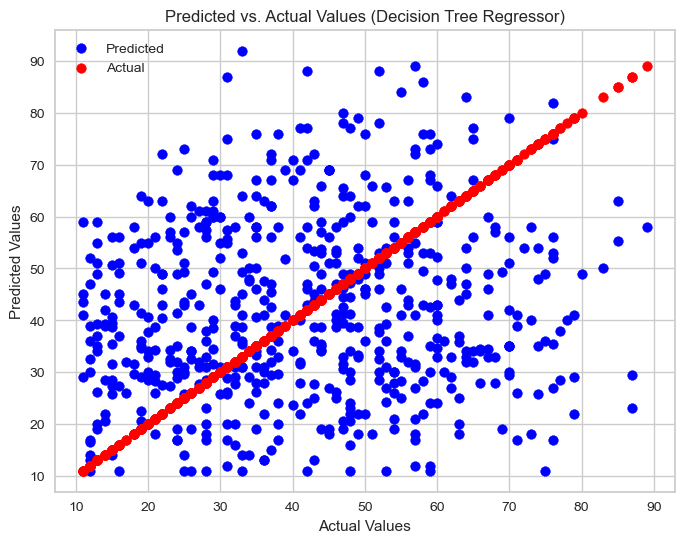

In [150]:



# Train and evaluate the Decision Tree Regressor model
dt_mse, dt_r2, dt_y_pred, dt_model = evaluate_decision_tree(X_train, y_train, X_test, y_test)

# Print evaluation metrics
print("Decision Tree Regression - Mean Squared Error:", dt_mse)
print("Decision Tree Regression - R-squared:", dt_r2)

# Visualize predictions and residuals
visualize_predictions_dt(y_test, dt_y_pred)


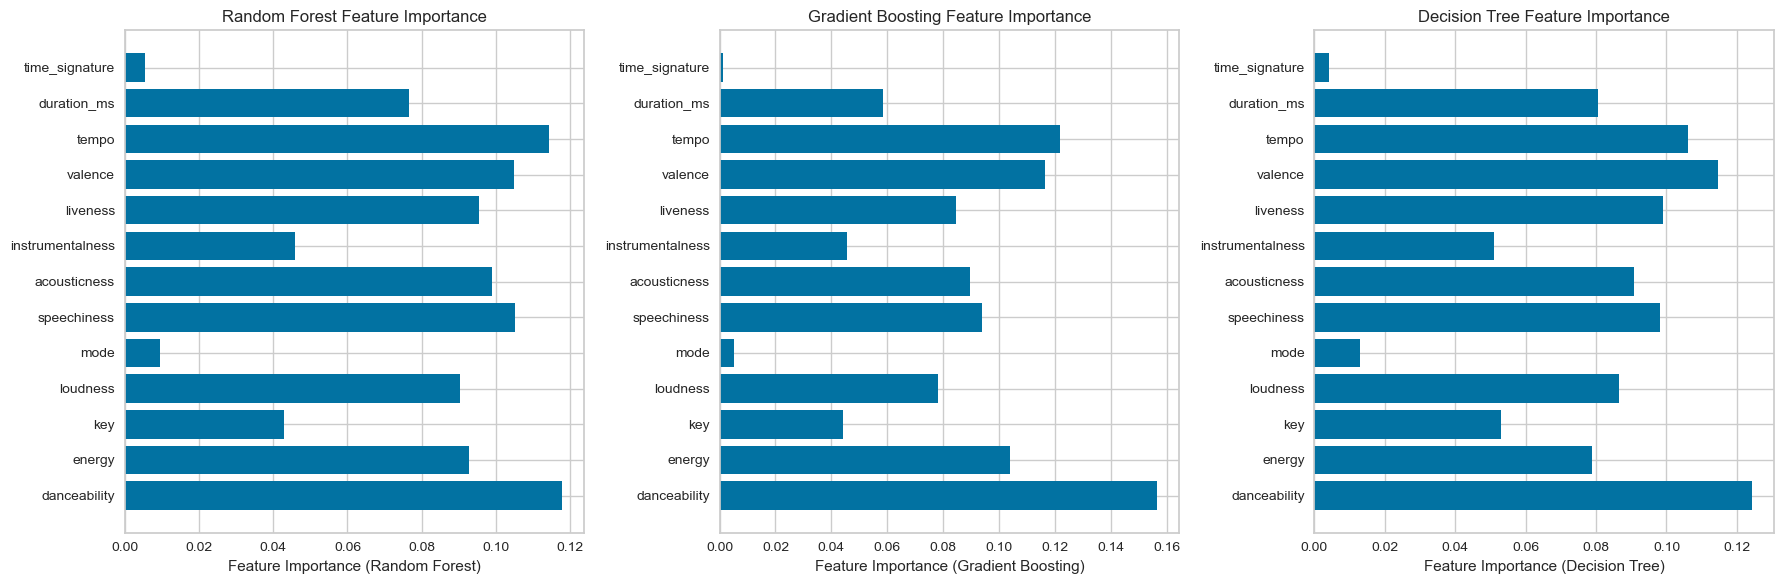

In [151]:

# Get feature importances from the models
rf_feature_importances = rf_model.feature_importances_
gb_feature_importances = gb_model.feature_importances_
dt_feature_importances = dt_model.feature_importances_

feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                 'duration_ms', 'time_signature']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot Random Forest feature importances
axes[0].barh(feature_names, rf_feature_importances)
axes[0].set_xlabel('Feature Importance (Random Forest)')
axes[0].set_title('Random Forest Feature Importance')

# Plot Gradient Boosting feature importances
axes[1].barh(feature_names, gb_feature_importances)
axes[1].set_xlabel('Feature Importance (Gradient Boosting)')
axes[1].set_title('Gradient Boosting Feature Importance')

# Plot Decision Tree feature importances
axes[2].barh(feature_names, dt_feature_importances)
axes[2].set_xlabel('Feature Importance (Decision Tree)')
axes[2].set_title('Decision Tree Feature Importance')

plt.tight_layout()

# Show the plot
plt.show()


# MODELING WITH last.fm artist list DATASET

In [152]:
to_drop = ['track_name','track_id','type','id','uri','track_href','analysis_url']

In [153]:
tracks_modified =songs_lastfmlist.drop(labels = to_drop,axis =1)

In [154]:

def evaluate_linear_regression(X_train, y_train, X_test, y_test):
    # Create and train the linear regression model
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    # Print the summary of the linear regression model
    print(results.summary())

    # Add a constant (intercept) to the test feature matrix
    X_test = sm.add_constant(X_test)

    # Evaluate the model on the test set
    y_pred = results.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, y_pred, results

def visualize_predictions_lr(y_test, y_pred):
    visualizer_lr = PredictionError(lr_model)
    visualizer_lr.fit(X_train, y_train)
    visualizer_lr.score(X_test, y_test)
    visualizer_lr.poof()

def evaluate_random_forest(X_train, y_train, X_test, y_test):
    # Create and train the Random Forest Regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred_rf = rf_model.predict(X_test)

    # Calculate evaluation metrics
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    return mse_rf, r2_rf, y_pred_rf, rf_model

def visualize_predictions(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')  # Actual values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values")
    plt.legend()
    plt.show()


def evaluate_gradient_boosting(X_train, y_train, X_test, y_test):
    # Create a Gradient Boosting Regressor model
    gb_model = GradientBoostingRegressor(random_state=42)

    # Fit the model to your training data
    gb_model.fit(X_train, y_train)

    # Predict using the test data
    gb_y_pred = gb_model.predict(X_test)

    # Evaluate the model using MSE and R-squared
    gb_mse = mean_squared_error(y_test, gb_y_pred)
    gb_r2 = r2_score(y_test, gb_y_pred)

    return gb_mse, gb_r2, gb_y_pred, gb_model

def visualize_predictions_gb(y_test, gb_y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, gb_y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')  # Actual values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values (Gradient Boosting Regressor)")
    plt.legend()
    plt.show()
    

def evaluate_decision_tree(X_train, y_train, X_test, y_test):
    # Create a Decision Tree Regressor model
    dt_model = DecisionTreeRegressor(random_state=42)

    # Fit the model to your training data
    dt_model.fit(X_train, y_train)

    # Predict using the test data
    dt_y_pred = dt_model.predict(X_test)

    # Evaluate the model using MSE and R-squared
    dt_mse = mean_squared_error(y_test, dt_y_pred)
    dt_r2 = r2_score(y_test, dt_y_pred)

    return dt_mse, dt_r2, dt_y_pred, dt_model

def visualize_predictions_dt(y_test, dt_y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, dt_y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')  # Actual values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values (Decision Tree Regressor)")
    plt.legend()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     20.62
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           4.54e-47
Time:                        03:34:02   Log-Likelihood:                -10621.
No. Observations:                2588   AIC:                         2.127e+04
Df Residuals:                    2574   BIC:                         2.135e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               88.1126      5.409  

C:\Users\yjain\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



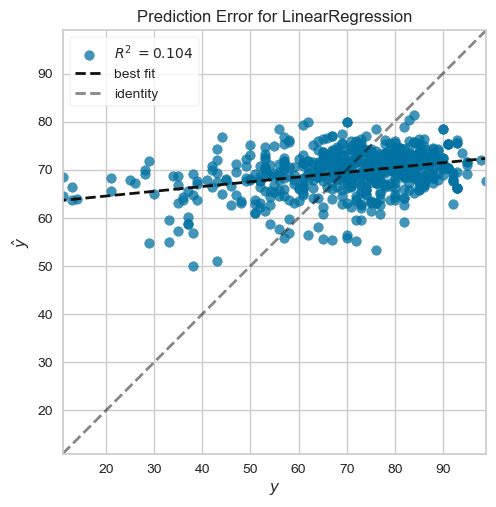

In [155]:
# Split the dataset into training and testing sets (first part)
X_train, X_test, y_train, y_test = train_test_split(
    tracks_modified.drop('track_popularity', axis=1),
    tracks_modified['track_popularity'],
    test_size=0.2,
    random_state=42
)

# Train and evaluate the linear regression model (first part)
mse, r2, y_pred, results = evaluate_linear_regression(X_train, y_train, X_test, y_test)

# Print evaluation metrics (first part)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize predictions and residuals (second part)
visualize_predictions_lr(y_test, y_pred)


Random Forest Regression - Mean Squared Error: 134.06119753086418
Random Forest Regression - R-squared: 0.4309760972963508


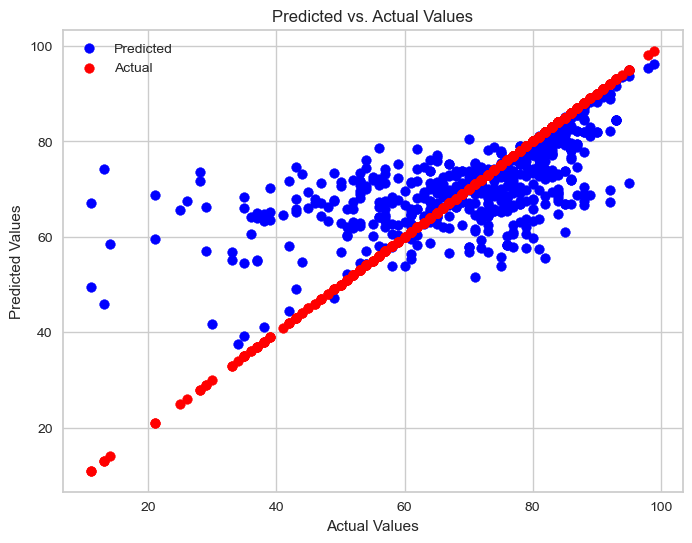

In [156]:
# Train and evaluate the Random Forest Regressor model
mse_rf, r2_rf, y_pred_rf, rf_model = evaluate_random_forest(X_train, y_train, X_test, y_test)

# Print evaluation metrics
print("Random Forest Regression - Mean Squared Error:", mse_rf)
print("Random Forest Regression - R-squared:", r2_rf)

# Visualize predictions and residuals
visualize_predictions(y_test, y_pred_rf)



Gradient Boosting Regression - Mean Squared Error: 184.7497354449099
Gradient Boosting Regression - R-squared: 0.21582816338690003


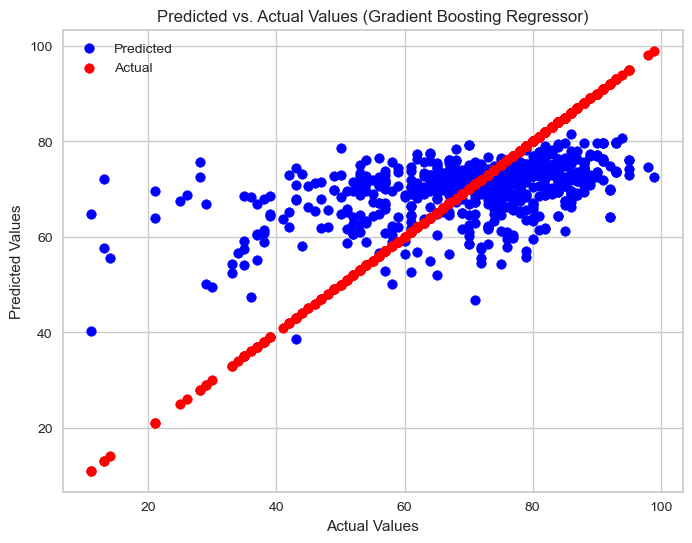

In [157]:


# Train and evaluate the Gradient Boosting Regressor model
gb_mse, gb_r2, gb_y_pred, gb_model = evaluate_gradient_boosting(X_train, y_train, X_test, y_test)

# Print evaluation metrics
print("Gradient Boosting Regression - Mean Squared Error:", gb_mse)
print("Gradient Boosting Regression - R-squared:", gb_r2)

# Visualize predictions and residuals
visualize_predictions_gb(y_test, gb_y_pred)


Decision Tree Regression - Mean Squared Error: 249.18672839506172
Decision Tree Regression - R-squared: -0.057675205837751875


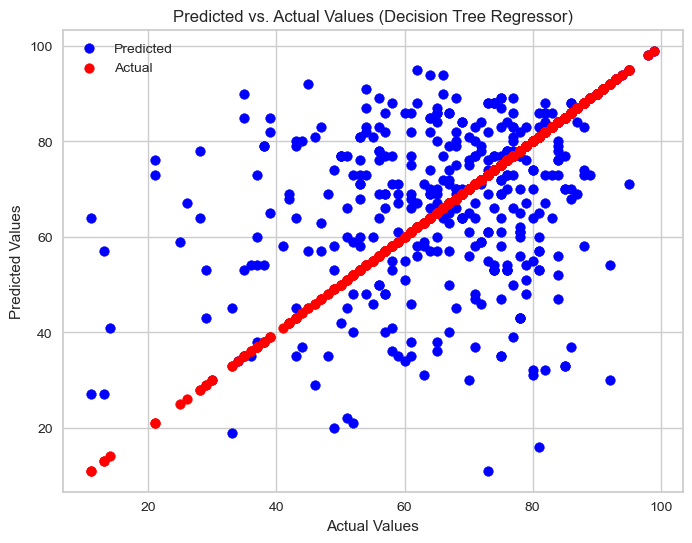

In [158]:



# Train and evaluate the Decision Tree Regressor model
dt_mse, dt_r2, dt_y_pred, dt_model = evaluate_decision_tree(X_train, y_train, X_test, y_test)

# Print evaluation metrics
print("Decision Tree Regression - Mean Squared Error:", dt_mse)
print("Decision Tree Regression - R-squared:", dt_r2)

# Visualize predictions and residuals
visualize_predictions_dt(y_test, dt_y_pred)


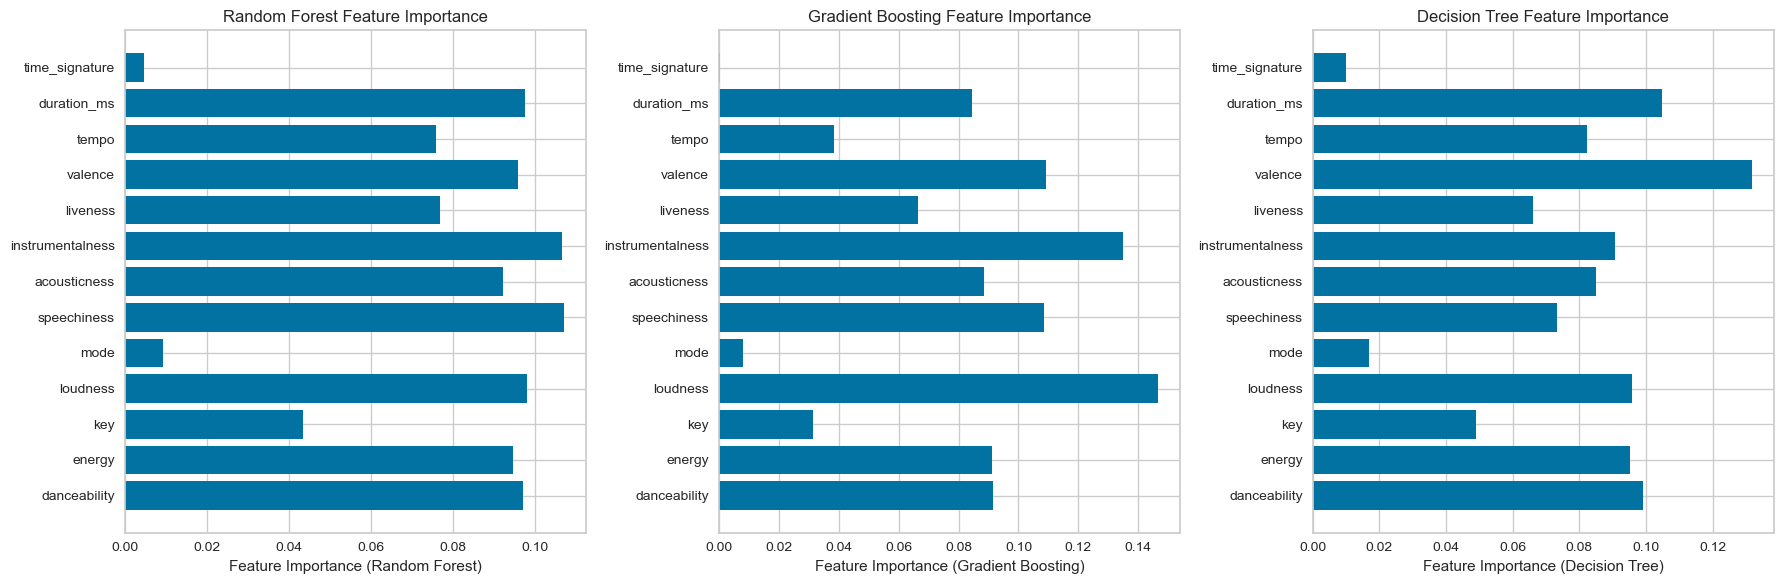

In [159]:

# Get feature importances from the models
rf_feature_importances = rf_model.feature_importances_
gb_feature_importances = gb_model.feature_importances_
dt_feature_importances = dt_model.feature_importances_

feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                 'duration_ms', 'time_signature']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot Random Forest feature importances
axes[0].barh(feature_names, rf_feature_importances)
axes[0].set_xlabel('Feature Importance (Random Forest)')
axes[0].set_title('Random Forest Feature Importance')

# Plot Gradient Boosting feature importances
axes[1].barh(feature_names, gb_feature_importances)
axes[1].set_xlabel('Feature Importance (Gradient Boosting)')
axes[1].set_title('Gradient Boosting Feature Importance')

# Plot Decision Tree feature importances
axes[2].barh(feature_names, dt_feature_importances)
axes[2].set_xlabel('Feature Importance (Decision Tree)')
axes[2].set_title('Decision Tree Feature Importance')

plt.tight_layout()

# Show the plot
plt.show()
